<a href="https://colab.research.google.com/github/ericdnbn/housing_price_modeling/blob/master/Housing_Price_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
# Functions

def get_results(results):

    '''Prints the mean negative rmse from the model that had the lowest mean rmse'''

    print('The best model parameters produce a mean rmse score on train data of:')
    print(results.cv_results_['mean_train_neg_root_mean_squared_error'][results.best_index_])
    print('')
    print('The best model parameters produce a mean R-squared score on train data of:')
    print(results.cv_results_['mean_train_r2'][results.best_index_])
    print('')
    print('The best model parameters produce a mean rmse score on test data of:')
    print(results.cv_results_['mean_test_neg_root_mean_squared_error'][results.best_index_])
    print('')
    print('The best model parameters produce a mean R-squared score on test data of:')
    print(results.cv_results_['mean_test_r2'][results.best_index_])

    
def replace_NaN(df, features, value):
    for feature in features:
        df[feature].replace(np.NaN, value , inplace=True)
        

categories = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

scale_dict = dict(zip(categories, range(0,6)))

def scale_function(category):
    return scale_dict[category]


def map_function(df, features, function):
    '''maps certain categorical variables to numerical values'''
    for feature in features:
        df[feature] = df[feature].map(lambda x : function(str(x)))
        

def get_cv_results(cv):
    train_scores = cv['train_score']
    mean_train_score = cv['train_score'].mean()
    test_scores = cv['test_score']
    mean_test_score = cv['test_score'].mean()
    print(cv)
    print('')
    print(f'CV Train Scores: {train_scores}')
    print('')
    print(f'Mean CV Train Score: {mean_train_score}')
    print('')
    print(f'CV Test Scores: {test_scores}')
    print('')
    print(f'Mean CV Test Score: {mean_test_score}')
    
    
def train_error_distribution(y, y_hat):
    train_error = y - y_hat
    plt.scatter(y_hat, train_error)
    plt.title('Distribution Of Training Error')
    plt.ylabel('Error')
    plt.xlabel('Prediction');
    

def test_error_distribution(y, y_hat):
    test_error = y_val - y_hat
    plt.scatter(y_hat, test_error)
    plt.title('Distribution Of Testing Error')
    plt.ylabel('Error')
    plt.xlabel('Prediction');
    

def train_error_distribution_log(y, y_hat):
    train_error = (np.exp(y) - np.exp(y_hat))**2
    plt.hist(train_error, bins=20)
    plt.title('Distribution Of Training Error')
    plt.ylabel('Error')
    plt.xlabel('Prediction');
    

def test_error_distribution_log(y, y_hat):
    test_error = (np.exp(y_val) - np.exp(y_hat))**2
    plt.hist(test_error, bins=20)
    plt.title('Distribution Of Testing Error')
    plt.ylabel('Frequency')
    plt.xlabel('Testing Error');

# EDA

In [4]:
train_df = pd.read_csv('data/train.csv')

In [5]:
train_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
train_df.shape

(1460, 81)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Predictors that need to be dropped, because of too many null values – ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [8]:
train_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [9]:
target = train_df['SalePrice']

In [10]:
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

By using a log transformation on the target variable, the distribution is now closer to normal. Hopefully this satisfies the assumption of normality. We will only truly know when we see the distribution of the errors of a baseline linear regression model.

## Checking Viability of Linear Model

### Checking Linear Relationships Between Predictors And Target


In [11]:
num_cols = list(train_df.select_dtypes(exclude=['object']))
len(num_cols)

38

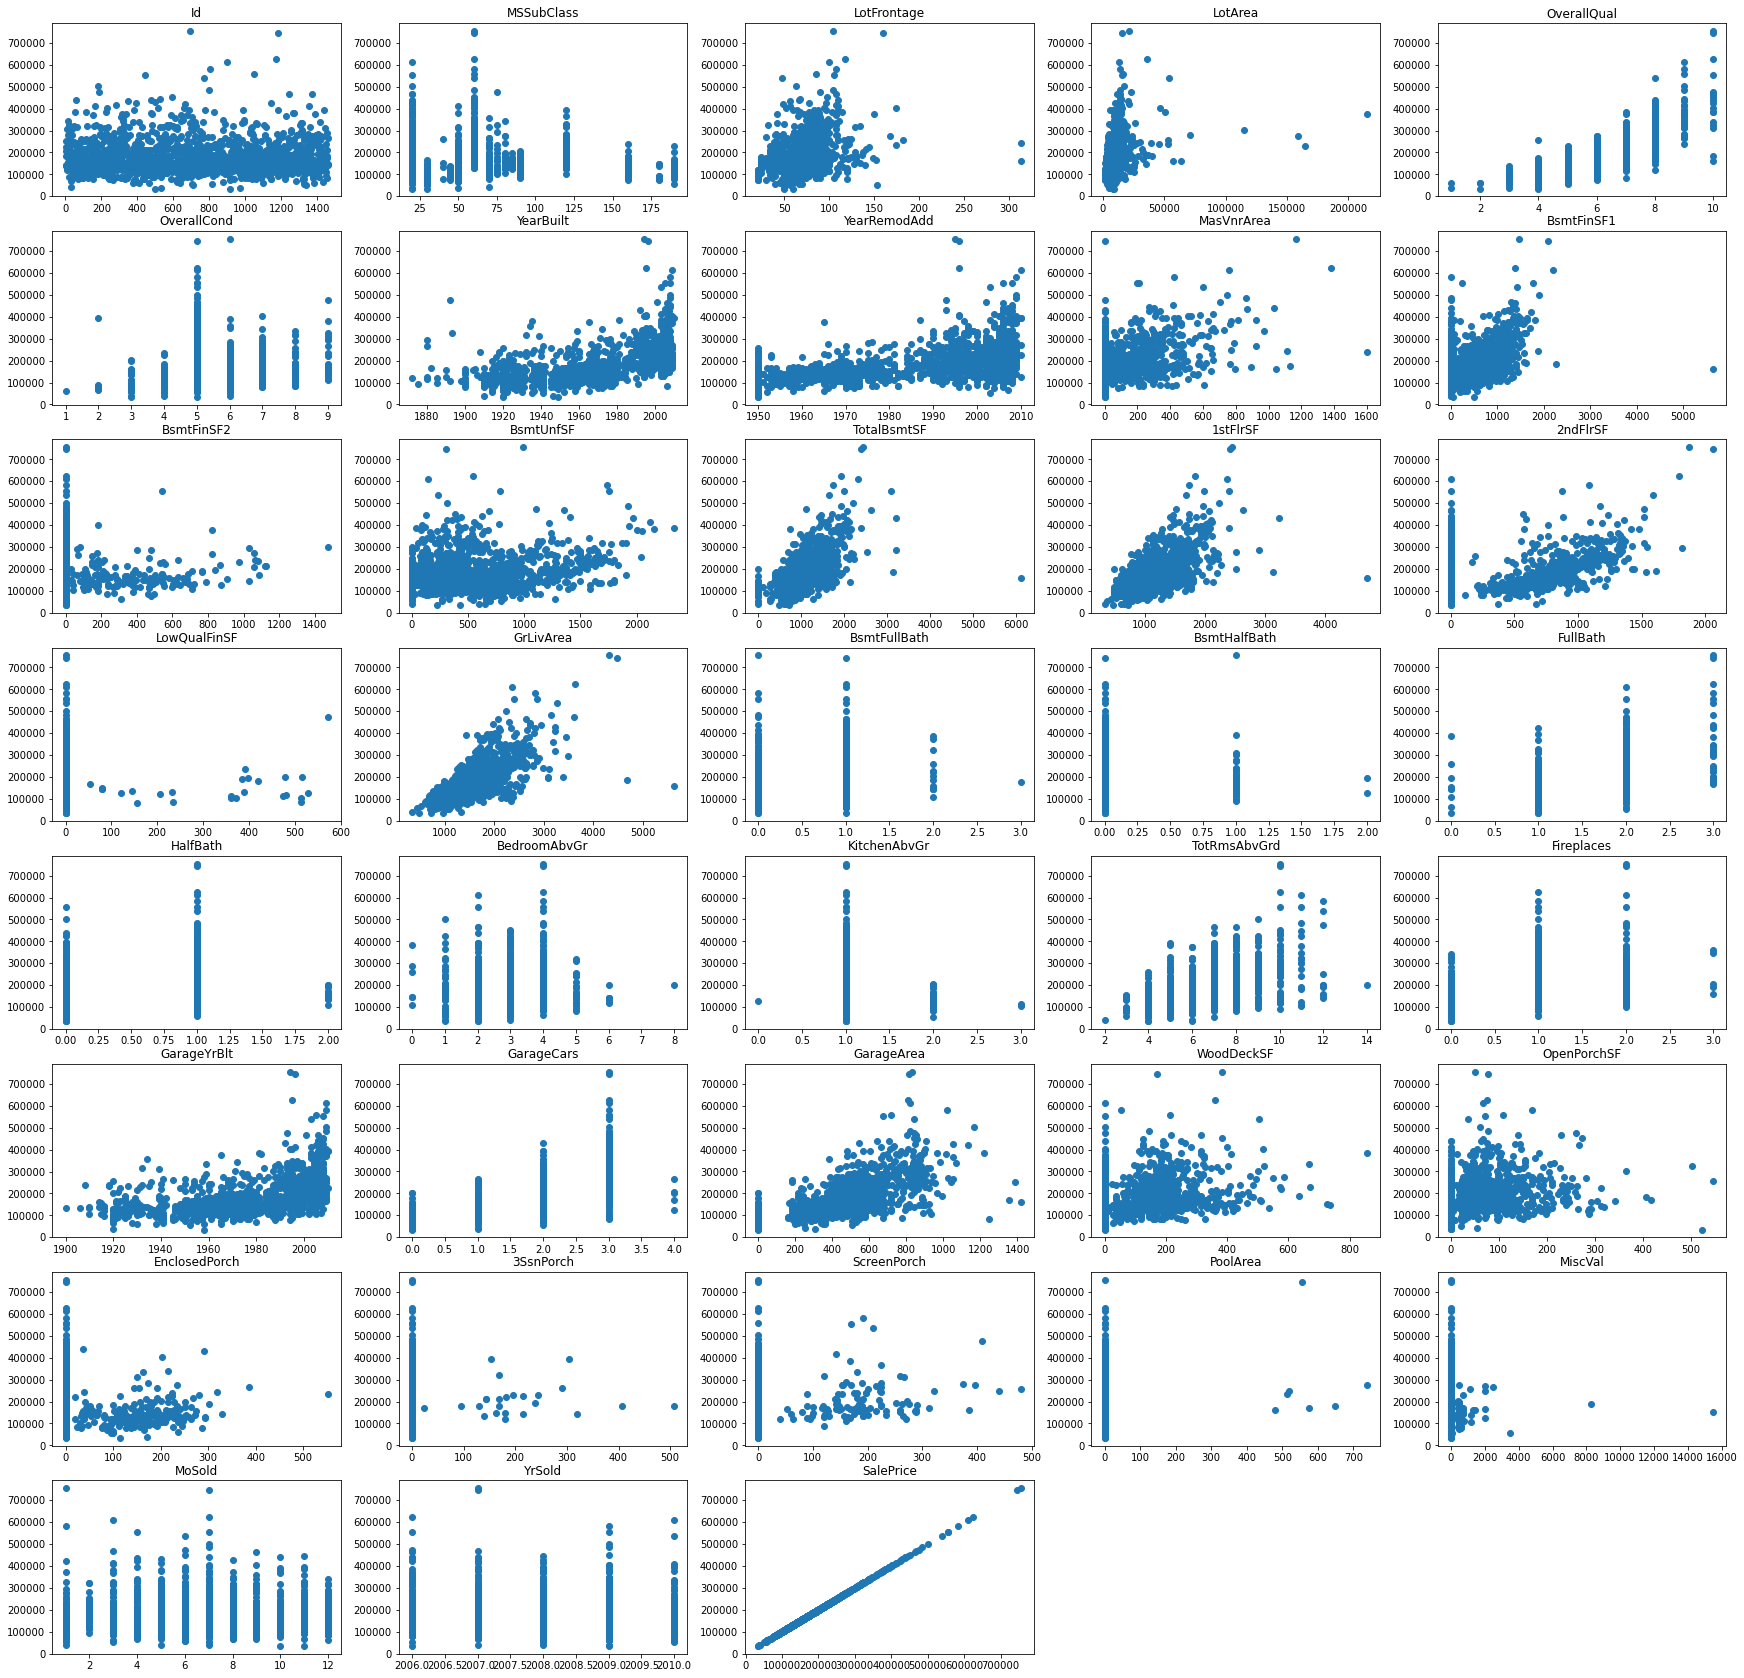

In [12]:
fig = plt.figure(1, figsize=(30,30))
columns = 5
rows = 8

for i, col in enumerate(num_cols):
    fig.add_subplot(rows, columns, i+1)
    plt.scatter(train_df[col], train_df['SalePrice'])
    plt.title(col);

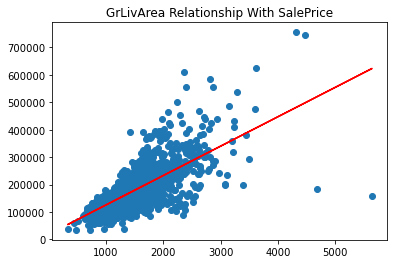

In [13]:
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'])
theta = np.polyfit(train_df['GrLivArea'], train_df['SalePrice'], 1)
line = theta[1] + theta[0]*train_df['GrLivArea']
plt.plot(train_df['GrLivArea'],line, 'r')
plt.title('GrLivArea Relationship With SalePrice');

The independent variables that do appear to have a linear relationship with the target are 'MSSubClass', 'KitchensAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', and 'MiscVal'. I will consider dropping some there variables during the feature selection stage

### Checking Multivariate Normality

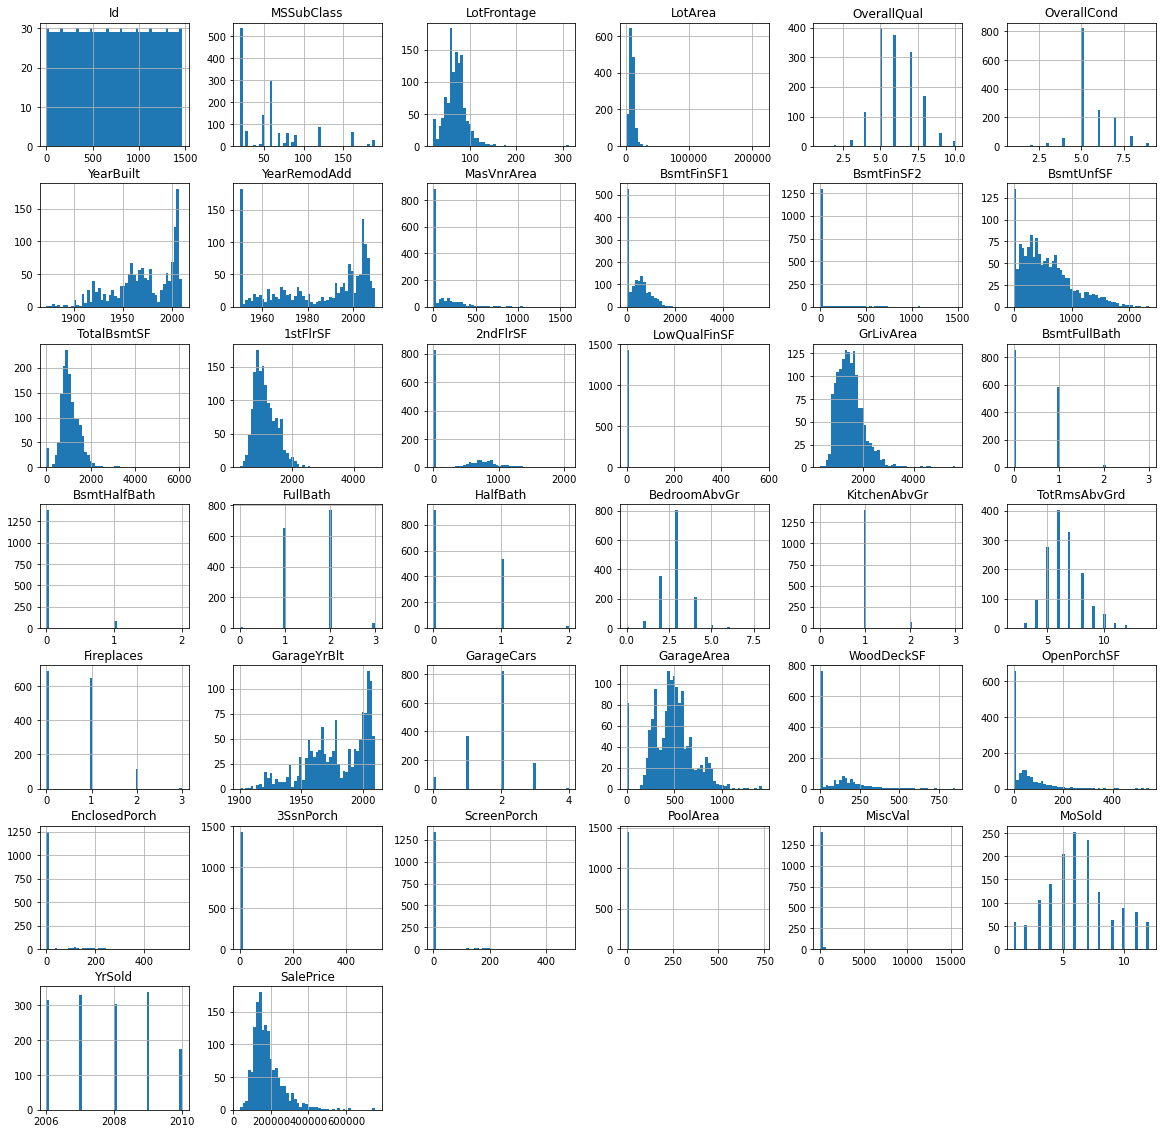

In [14]:
train_df.hist(figsize=(20,20), bins=50);

It appears that many variables in this dataset are slightly non-normally distributed. However, this is most likely an effect of the outliers, which I would like to keep for now in an effort to model the real world. And given that predictors with continous values that are not in units of time, such as 'LotFrontage' and 'LotArea', are mostly normal, I am going to try training models on just a standard scaled raw dataset.


### Checking For Multicollinearity

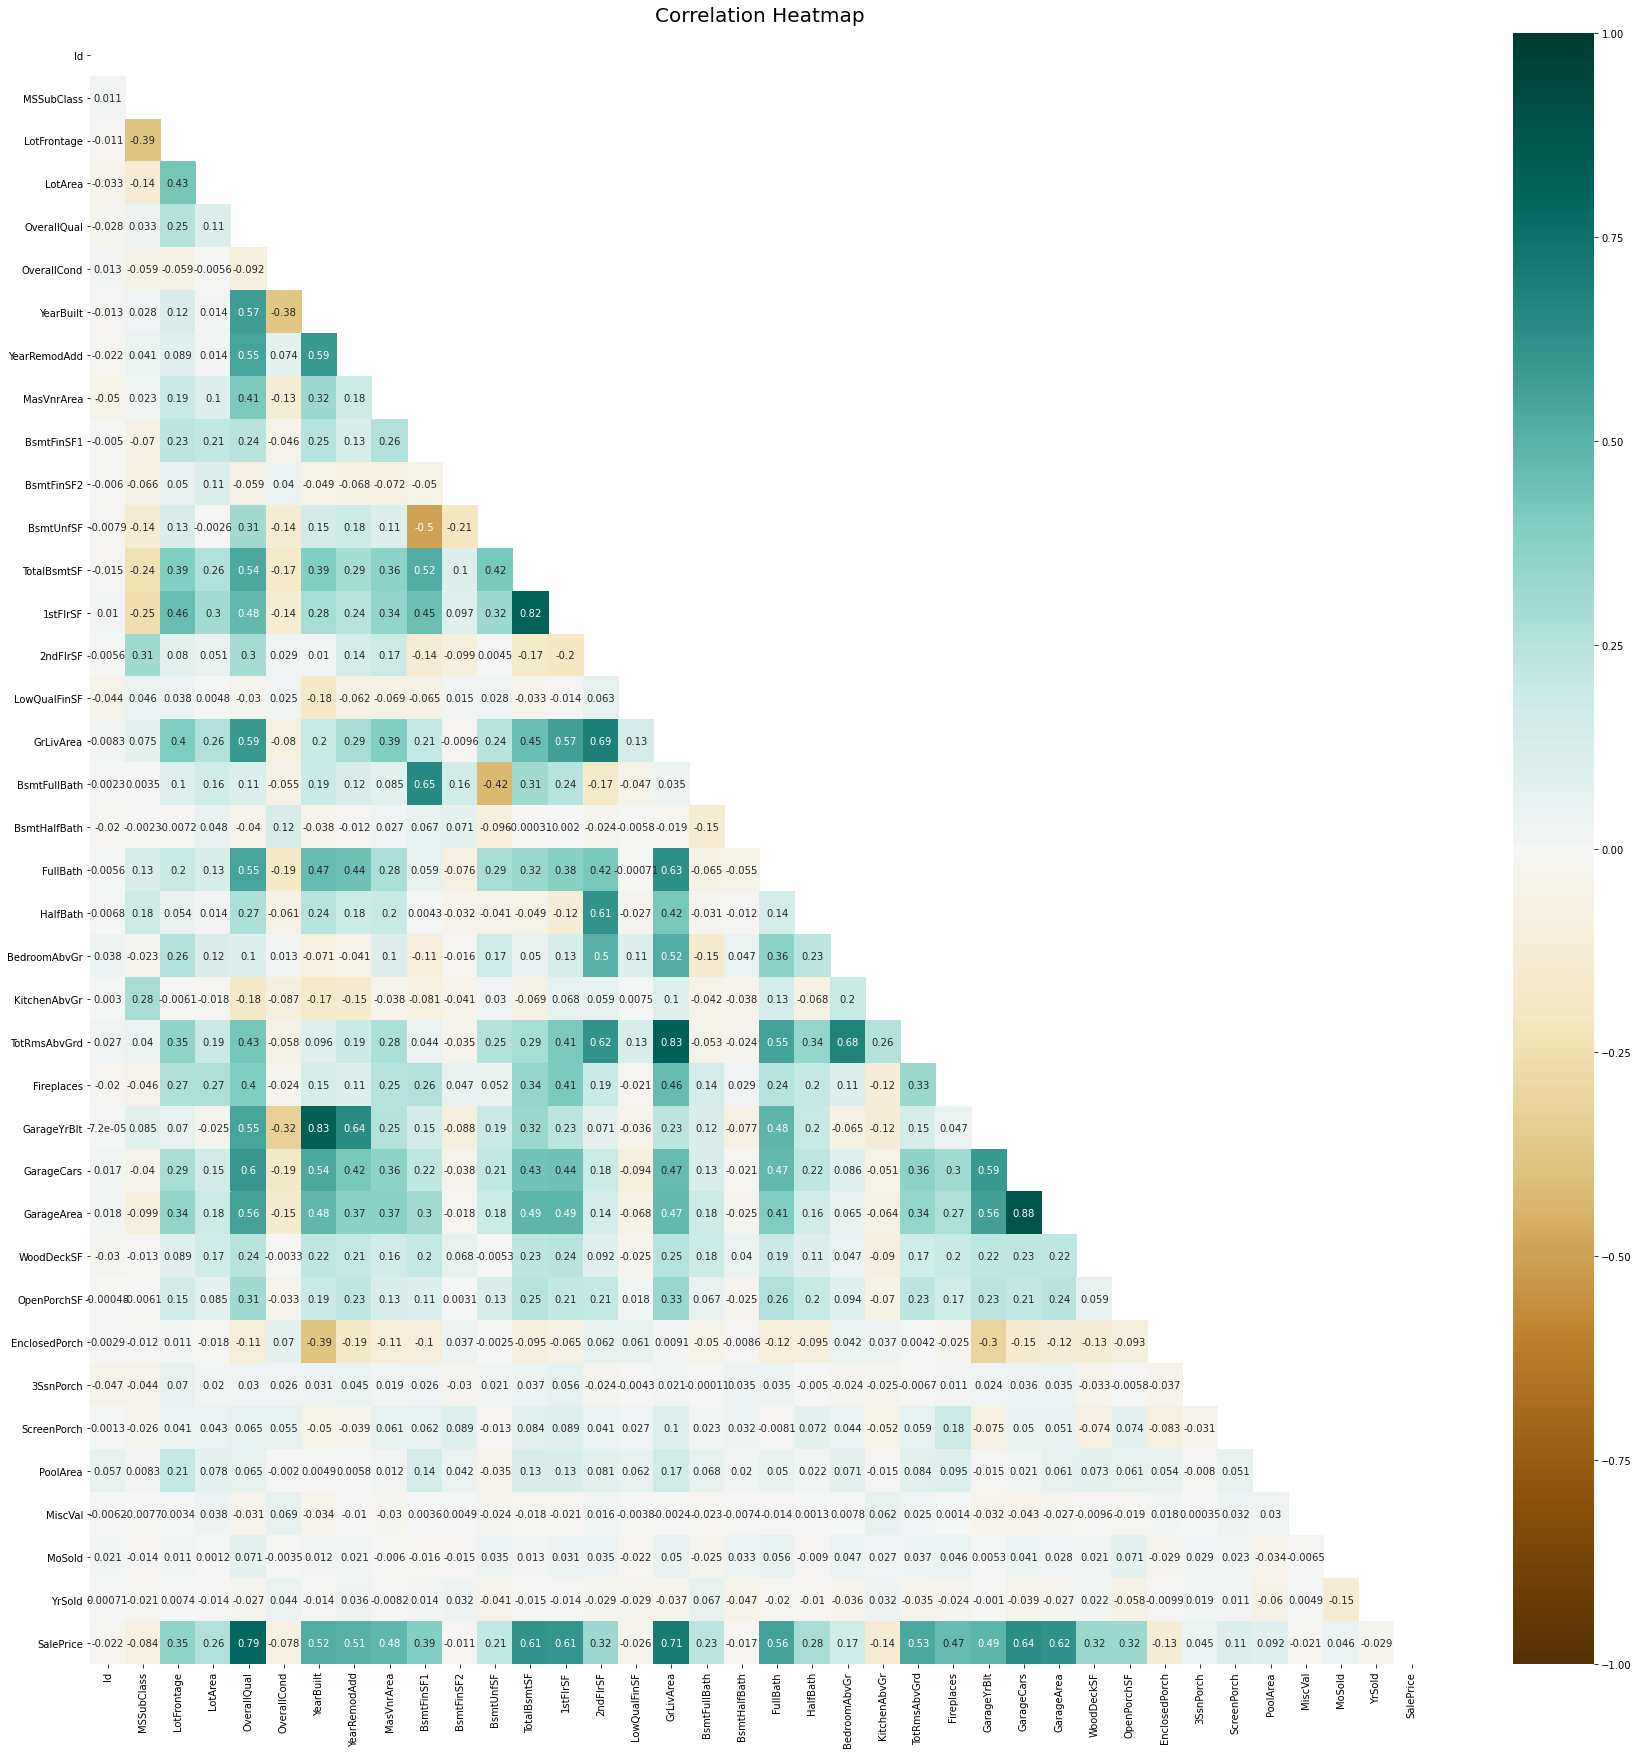

In [15]:
plt.figure(figsize=(30, 30))
mask = np.triu(np.ones_like(train_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

There are a few dark green points on the heatmap indicating a high correlation between two variables. When I start the process of data cleaning, I will take out multicollinear variables.

### Checking Homoscedasticity of Target

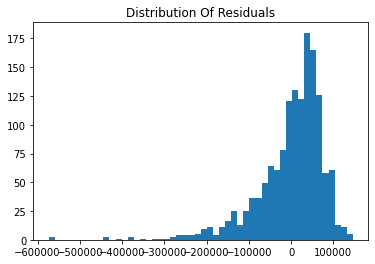

In [16]:
# Using the mean of the target as a theoretical prediction for each observation to calculate baseline residuals
plt.hist((train_df['SalePrice'].mean() - train_df['SalePrice']), bins=50)
plt.title('Distribution Of Residuals');

It is clear that this distribution of residuals skews left, however not terribly. Using linear regression is feasible, though multicollinearity needs to be reduced. I will check the residuals of the first basic linear regression for homoscedasticity.

# Data Preprocessing

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [18]:
# This dataset already contains very little data, and given the description, Lot Frontage is an important variable
# So I am replacing null values of Lot Frontage with the variable mean, to avoid dropping the 200+ rows of data,
# or dropping the variable entirele
def impute_lot_frontage(row):
    if np.isnan(row['LotFrontage']):
        neighborhood = row['Neighborhood']
        lot_frontage_mean = train_df[train_df['Neighborhood'] == neighborhood]['LotFrontage'].mean()
        row['LotFrontage'] = lot_frontage_mean
    
    return row

In [19]:
train_df = train_df.apply(impute_lot_frontage, axis=1)

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [21]:
# Replacing NaN values in certain garage features to 'U' for Unknown 
replace_NaN(train_df, ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], 'U')

# Feature Selection And Engineering

In [22]:
# Finding Multicollinear Predictors
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
train_df_mc = train_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# rename correlation column as cc rather than 0
train_df_mc.columns = 'v1', 'v2', 'corr'

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
train_df_mc.drop_duplicates(inplace=True)

# reset index for future concatenation
train_df_mc.reset_index(inplace=True)

In [23]:
def corr_target(row):
    row['v1_y_corr'] = train_df.corr()['SalePrice'][row['v1']]
    row['v2_y_corr'] = train_df.corr()['SalePrice'][row['v2']]
    return row

In [24]:
train_df_mc = train_df_mc.apply(corr_target, axis=1)

In [25]:
train_df_mc['pairs'] = list(zip(train_df_mc.v1, train_df_mc.v2))

# drop level columns
train_df_mc.drop(columns=['index','v1', 'v2'], inplace = True)

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
train_df_mc.drop_duplicates('corr', inplace=True)

# set index to pairs
train_df_mc.set_index(['pairs'], inplace = True)

train_df_mc

corr  v1_y_corr  v2_y_corr
pairs                                                      
(Id, Id)                     1.000000  -0.021917  -0.021917
(GarageCars, GarageArea)     0.882475   0.640409   0.623431
(YearBuilt, GarageYrBlt)     0.825667   0.522897   0.486362
(GrLivArea, TotRmsAbvGrd)    0.825489   0.708624   0.533723
(1stFlrSF, TotalBsmtSF)      0.819530   0.605852   0.613581
...                               ...        ...        ...
(Id, OpenPorchSF)            0.000477  -0.021917   0.315856
(MiscVal, 3SsnPorch)         0.000354  -0.021190   0.044584
(TotalBsmtSF, BsmtHalfBath)  0.000315   0.613581  -0.016844
(BsmtFullBath, 3SsnPorch)    0.000106   0.227122   0.044584
(Id, GarageYrBlt)            0.000072  -0.021917   0.486362

[704 rows x 3 columns]

In [26]:
multicollinear = train_df_mc[(train_df_mc['corr'] > 0.7) & (train_df_mc['corr'] < 1)]
multicollinear

corr  v1_y_corr  v2_y_corr
pairs                                                    
(GarageCars, GarageArea)   0.882475   0.640409   0.623431
(YearBuilt, GarageYrBlt)   0.825667   0.522897   0.486362
(GrLivArea, TotRmsAbvGrd)  0.825489   0.708624   0.533723
(1stFlrSF, TotalBsmtSF)    0.819530   0.605852   0.613581
(SalePrice, OverallQual)   0.790982   1.000000   0.790982
(SalePrice, GrLivArea)     0.708624   1.000000   0.708624

GaragesCars is more highly correlated with SalePrice than GarageArea, so GarageArea will be dropped.

YearBuilt is more highly correlated with SalePrice than GarageYrBlt, so GarageYrBlt will be dropped.

GrLivArea is more highly correlated with SalePrice than TotRmsAbvGrd, so TotRmsAbvGrd will be dropped.

TotBsmtSF is more highly correlated with SalePrice than 1stFlrSF, so 1stFlrSF will be dropped.

In [27]:
# Dropping 'Id' column
train_df.drop('Id', axis=1, inplace=True)

In [28]:
# Dropping predictors with too many null values
train_df.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [29]:
# Dropping multicollinear predictors
train_df.drop(['GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF'], axis=1, inplace=True)

In [30]:
# Dropping low variance predictors, because they will have little effect on the model
var = train_df.var().sort_values(ascending=True)
low_var = var[var <.1]
low_var = list(low_var.index)
train_df.drop(low_var, axis=1, inplace=True)

In [31]:
mid_var = var[var < .5]
mid_var

KitchenAbvGr    0.048549
BsmtHalfBath    0.057003
HalfBath        0.252894
BsmtFullBath    0.269268
FullBath        0.303508
Fireplaces      0.415595
dtype: float64

In [32]:
# Dropping predictors not linearly related to the target
train_df.drop(['MSSubClass'], axis=1, inplace=True)
train_df.drop(['MSSubClass', 'BsmtFullBath', 'HalfBath', 'MiscVal'], axis=1, inplace=True)

In [33]:
# Dropping remaining null values
train_df.dropna(inplace=True)

In [34]:
# Turning these predictors from categorical into numerical
map_function(train_df, ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual'], scale_function)

In [35]:
# Combining the weaker mid_var predictors to try and give them more predictive power
train_df['Bath_Fireplaces'] = train_df['Fireplaces'] + train_df['FullBath']

In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412 entries, 0 to 1459
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1412 non-null   object 
 1   LotFrontage    1412 non-null   float64
 2   LotArea        1412 non-null   int64  
 3   Street         1412 non-null   object 
 4   LotShape       1412 non-null   object 
 5   LandContour    1412 non-null   object 
 6   Utilities      1412 non-null   object 
 7   LotConfig      1412 non-null   object 
 8   LandSlope      1412 non-null   object 
 9   Neighborhood   1412 non-null   object 
 10  Condition1     1412 non-null   object 
 11  Condition2     1412 non-null   object 
 12  BldgType       1412 non-null   object 
 13  HouseStyle     1412 non-null   object 
 14  OverallQual    1412 non-null   int64  
 15  OverallCond    1412 non-null   int64  
 16  YearBuilt      1412 non-null   int64  
 17  YearRemodAdd   1412 non-null   int64  
 18  RoofStyl

# Modeling

## Baseline Models 

### *disclaimer* *
It is hard to say with any certainty how the values imputed to the lot frontage variable will effect the results of the models

In [37]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [38]:
x_train

MSZoning  LotFrontage  LotArea Street LotShape LandContour Utilities  \
0          RL         65.0     8450   Pave      Reg         Lvl    AllPub   
1          RL         80.0     9600   Pave      Reg         Lvl    AllPub   
2          RL         68.0    11250   Pave      IR1         Lvl    AllPub   
3          RL         60.0     9550   Pave      IR1         Lvl    AllPub   
4          RL         84.0    14260   Pave      IR1         Lvl    AllPub   
...       ...          ...      ...    ...      ...         ...       ...   
1455       RL         62.0     7917   Pave      Reg         Lvl    AllPub   
1456       RL         85.0    13175   Pave      Reg         Lvl    AllPub   
1457       RL         66.0     9042   Pave      Reg         Lvl    AllPub   
1458       RL         68.0     9717   Pave      Reg         Lvl    AllPub   
1459       RL         75.0     9937   Pave      Reg         Lvl    AllPub   

     LotConfig LandSlope Neighborhood  ... OpenPorchSF EnclosedPorch  \
0       Inside       Gtl      CollgCr  ...          61             0   
1          FR2       Gtl      Veenker  ...           0             0   
2       Inside       Gtl      CollgCr  ...          42             0   
3       Corner       Gtl      Crawfor  ...          35           272   
4          FR2       Gtl      NoRidge  ...          84             0   
...        ...       ...          ...  ...         ...           ...   
1455    Inside       Gtl      Gilbert  ...          40             0   
1456    Inside       Gtl       NWAmes  ...           0             0   
1457    Inside       Gtl      Crawfor  ...          60             0   
1458    Inside       Gtl        NAmes  ...           0           112   
1459    Inside       Gtl      Edwards  ...          68             0   

     3SsnPorch ScreenPorch  PoolArea  MiscVal  MoSold  YrSold SaleType  \
0            0           0         0        0       2    2008       WD   
1            0           0         0        0       5    2007       WD   
2            0           0         0        0       9    2008       WD   
3            0           0         0        0       2    2006       WD   
4            0           0         0        0      12    2008       WD   
...        ...         ...       ...      ...     ...     ...      ...   
1455         0           0         0        0       8    2007       WD   
1456         0           0         0        0       2    2010       WD   
1457         0           0         0     2500       5    2010       WD   
1458         0           0         0        0       4    2010       WD   
1459         0           0         0        0       6    2008       WD   

     SaleCondition  
0           Normal  
1           Normal  
2           Normal  
3          Abnorml  
4           Normal  
...            ...  
1455        Normal  
1456        Normal  
1457        Normal  
1458        Normal  
1459        Normal  

[1412 rows x 67 columns]

In [39]:
categorical_cols = x_train.select_dtypes('object')
numerical_cols = x_train.select_dtypes(exclude=['object'])

categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])
numerical_transformer = Pipeline(steps=[('ss', StandardScaler())])

transformer = ColumnTransformer(transformers=[('numerical', numerical_transformer, numerical_cols.columns),
                                              ('categorical', categorical_transformer, categorical_cols.columns)
                                             ])

#cat_transformer = ColumnTransformer(transformers=[('categorical', categorical_trans, categorical_cols.columns)])

In [40]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=22)

# Transforming x_tr and x_val separately to avoid data leakage
x_tr = transformer.fit_transform(x_tr)

x_val = transformer.transform(x_val)


# Instantiating and fitting model
linreg =  LinearRegression(normalize=False)

results = linreg.fit(x_tr, y_tr)


# Getting Predictions
y_tr_preds = results.predict(x_tr)
y_val_preds = results.predict(x_val)


# Getting R squared scores for training and testing data
y_tr_r2 = r2_score(y_tr, y_tr_preds)
y_val_r2 = r2_score(y_val, y_val_preds)

print(f'R-Squared score for the training data: {y_tr_r2}')
print('')
print(f'R-Squared score for the testing data: {y_val_r2}')
print('')
print('')

# Getting Mean Squared Error for training and testing data
y_tr_rmse = mean_squared_error(y_tr, y_tr_preds, squared = False)
y_val_rmse = mean_squared_error(y_val, y_val_preds, squared = False)

print(f'Root Mean Squared Error for the training data: {y_tr_rmse}')
print('')
print(f'Root Mean Squared Error for the testing data: {y_val_rmse}')

R-Squared score for the training data: 0.9331750770169556

R-Squared score for the testing data: 0.7720238876259621


Root Mean Squared Error for the training data: 21213.739244053864

Root Mean Squared Error for the testing data: 33451.15066009637


The baseline model using log sale price with outliers shows significant overfitting.

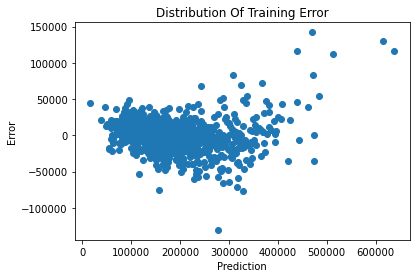

In [41]:
train_error_distribution(y_tr, y_tr_preds)

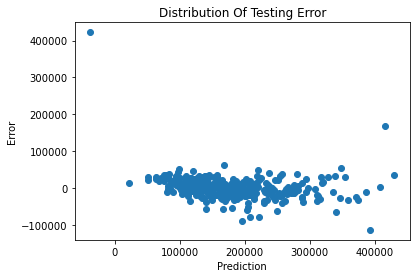

In [42]:
test_error_distribution(y_val, y_val_preds)

It appears that for the most part, the test residuals pass the check for homoscedasticity

In [43]:
x_train = transformer.fit_transform(x_train)
cv = cross_validate(linreg, x_train, y_train, scoring='r2', cv=10, return_train_score=True)
get_cv_results(cv)

{'fit_time': array([0.146873  , 0.14387584, 0.14998293, 0.15857816, 0.14483404,
       0.14365506, 0.14901423, 0.15953422, 0.12439775, 0.1411221 ]), 'score_time': array([0.00053906, 0.00058007, 0.00057316, 0.00057197, 0.00056911,
       0.00057101, 0.00058174, 0.00062776, 0.00057316, 0.00056601]), 'test_score': array([0.85403637, 0.85207864, 0.91324391, 0.7334582 , 0.88745215,
       0.65151507, 0.87508573, 0.86369254, 0.48267977, 0.89650128]), 'train_score': array([0.92083528, 0.91980291, 0.91859153, 0.9283045 , 0.92006052,
       0.9317301 , 0.9215568 , 0.92242724, 0.92311113, 0.92064252])}

CV Train Scores: [0.92083528 0.91980291 0.91859153 0.9283045  0.92006052 0.9317301
 0.9215568  0.92242724 0.92311113 0.92064252]

Mean CV Train Score: 0.9227062529010697

CV Test Scores: [0.85403637 0.85207864 0.91324391 0.7334582  0.88745215 0.65151507
 0.87508573 0.86369254 0.48267977 0.89650128]

Mean CV Test Score: 0.8009743670393368


## Linear Regression With l2 Regularization

In [44]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [45]:
x_train

MSZoning  LotFrontage  LotArea Street LotShape LandContour Utilities  \
0          RL         65.0     8450   Pave      Reg         Lvl    AllPub   
1          RL         80.0     9600   Pave      Reg         Lvl    AllPub   
2          RL         68.0    11250   Pave      IR1         Lvl    AllPub   
3          RL         60.0     9550   Pave      IR1         Lvl    AllPub   
4          RL         84.0    14260   Pave      IR1         Lvl    AllPub   
...       ...          ...      ...    ...      ...         ...       ...   
1455       RL         62.0     7917   Pave      Reg         Lvl    AllPub   
1456       RL         85.0    13175   Pave      Reg         Lvl    AllPub   
1457       RL         66.0     9042   Pave      Reg         Lvl    AllPub   
1458       RL         68.0     9717   Pave      Reg         Lvl    AllPub   
1459       RL         75.0     9937   Pave      Reg         Lvl    AllPub   

     LotConfig LandSlope Neighborhood  ... OpenPorchSF EnclosedPorch  \
0       Inside       Gtl      CollgCr  ...          61             0   
1          FR2       Gtl      Veenker  ...           0             0   
2       Inside       Gtl      CollgCr  ...          42             0   
3       Corner       Gtl      Crawfor  ...          35           272   
4          FR2       Gtl      NoRidge  ...          84             0   
...        ...       ...          ...  ...         ...           ...   
1455    Inside       Gtl      Gilbert  ...          40             0   
1456    Inside       Gtl       NWAmes  ...           0             0   
1457    Inside       Gtl      Crawfor  ...          60             0   
1458    Inside       Gtl        NAmes  ...           0           112   
1459    Inside       Gtl      Edwards  ...          68             0   

     3SsnPorch ScreenPorch  PoolArea  MiscVal  MoSold  YrSold SaleType  \
0            0           0         0        0       2    2008       WD   
1            0           0         0        0       5    2007       WD   
2            0           0         0        0       9    2008       WD   
3            0           0         0        0       2    2006       WD   
4            0           0         0        0      12    2008       WD   
...        ...         ...       ...      ...     ...     ...      ...   
1455         0           0         0        0       8    2007       WD   
1456         0           0         0        0       2    2010       WD   
1457         0           0         0     2500       5    2010       WD   
1458         0           0         0        0       4    2010       WD   
1459         0           0         0        0       6    2008       WD   

     SaleCondition  
0           Normal  
1           Normal  
2           Normal  
3          Abnorml  
4           Normal  
...            ...  
1455        Normal  
1456        Normal  
1457        Normal  
1458        Normal  
1459        Normal  

[1412 rows x 67 columns]

In [46]:
ridge_pipeline = Pipeline(steps=[('trans', transformer), 
                                 ('model', Ridge(random_state=42))])

ridge_grid = {'model__alpha': [10.0, 20.0, 30.0, 40.0, 50.0, 75.0],
              'model__normalize': [False],
              'model__max_iter': [500,1000,2000],
              'model__tol': [.001, .0001],
              'model__solver': ['auto', 'sag']}

ridge_gs = GridSearchCV(ridge_pipeline, 
                        ridge_grid, 
                        scoring=['neg_root_mean_squared_error', 'r2'], 
                        refit='neg_root_mean_squared_error', 
                        cv=10, 
                        verbose=3,
                        return_train_score=True)

In [47]:
results = ridge_gs.fit(x_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-27328.845, test=-22267.092), r2=(train=0.884, test=0.892), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-27080.949, test=-25580.641), r2=(train=0.883, test=0.897), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-27063.743, test=-26212.245), r2=(train=0.883, test=0.891), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-25638.428, test=-39441.346), r2=(train=0.894, test=0.772), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-26195.128, test=-34924.123), r2=(train=0.884, test=0.869), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-26876.459, test=-27306.276), r2=(train=0.886, test=0.873), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-26831.347, test=-27464.034), r2=(train=0.887, test=0.861), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.0, mod

[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-27304.501, test=-22239.003), r2=(train=0.885, test=0.893), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-27057.961, test=-25624.090), r2=(train=0.883, test=0.897), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-27041.771, test=-26160.531), r2=(train=0.883, test=0.891), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=10.0, mod

[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-26807.299, test=-27460.080), r2=(train=0.887, test=0.861), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-26863.039, test=-26453.885), r2=(train=0.888, test=0.858), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-23556.445, test=-59996.790), r2=(train=0.909, test=0.526), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alp

[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-25638.428, test=-39441.346), r2=(train=0.894, test=0.772), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-26195.128, test=-34924.123), r2=(train=0.884, test=0.869), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-26876.459, test=-27306.276), r2=(train=0.886, test=0.873), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.

[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-27057.961, test=-25624.090), r2=(train=0.883, test=0.897), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-27041.771, test=-26160.531), r2=(train=0.883, test=0.891), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-25615.248, test=-39417.552), r2=(train=0.894, test=0.772), total=   0.1s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=10.

[CV]  model__alpha=20.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-24266.882, test=-60199.737), r2=(train=0.904, test=0.523), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=20.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-28005.854, test=-23470.102), r2=(train=0.877, test=0.895), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=20.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-28174.538, test=-22139.223), r2=(train=0.877, test=0.894), total=   0.0s
[CV] model__alpha=20.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=20.0, mod

[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-27753.714, test=-27193.600), r2=(train=0.878, test=0.874), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-27705.693, test=-27147.507), r2=(train=0.879, test=0.865), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-27785.104, test=-25842.872), r2=(train=0.880, test=0.865), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=20.

[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-27899.801, test=-25547.458), r2=(train=0.876, test=0.896), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-26419.090, test=-39577.726), r2=(train=0.888, test=0.771), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-26984.048, test=-35449.477), r2=(train=0.877, test=0.865), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=20.

[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-28005.854, test=-23470.102), r2=(train=0.877, test=0.895), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-28174.538, test=-22139.223), r2=(train=0.877, test=0.894), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-27914.076, test=-25909.040), r2=(train=0.876, test=0.894), total=   0.0s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=20.0, m

[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-28282.279, test=-26953.280), r2=(train=0.874, test=0.866), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-28373.791, test=-25646.197), r2=(train=0.875, test=0.867), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-24758.617, test=-60388.019), r2=(train=0.900, test=0.520), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=30.0, mod

[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-26947.414, test=-39728.472), r2=(train=0.883, test=0.769), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-27516.986, test=-35862.698), r2=(train=0.872, test=0.862), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-28305.830, test=-27361.176), r2=(train=0.873, test=0.872), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=30.0, mod

[CV]  model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-28732.587, test=-22237.323), r2=(train=0.872, test=0.893), total=   0.0s
[CV] model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-28460.315, test=-26192.902), r2=(train=0.871, test=0.892), total=   0.0s
[CV] model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-28486.768, test=-25209.109), r2=(train=0.871, test=0.899), total=   0.0s
[CV] model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=30.0, mod

[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-28373.791, test=-25646.197), r2=(train=0.875, test=0.867), total=   0.0s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-24758.617, test=-60388.019), r2=(train=0.900, test=0.520), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-28591.756, test=-23375.008), r2=(train=0.872, test=0.896), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=30

[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-27516.986, test=-35862.698), r2=(train=0.872, test=0.862), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-28305.830, test=-27361.176), r2=(train=0.873, test=0.872), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-28260.709, test=-26935.303), r2=(train=0.875, test=0.867), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=30.

[CV]  model__alpha=40.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-28874.630, test=-26296.241), r2=(train=0.867, test=0.891), total=   0.0s
[CV] model__alpha=40.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=40.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-28931.803, test=-24966.373), r2=(train=0.867, test=0.901), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=40.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-27367.643, test=-39844.187), r2=(train=0.880, test=0.767), total=   0.0s
[CV] model__alpha=40.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=40.0, model__ma

[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-25115.703, test=-60590.722), r2=(train=0.897, test=0.516), total=   0.0s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-29022.403, test=-23445.304), r2=(train=0.868, test=0.896), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-29144.004, test=-22186.582), r2=(train=0.869, test=0.893), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=

[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-28738.672, test=-27517.167), r2=(train=0.869, test=0.871), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-28708.016, test=-26862.533), r2=(train=0.871, test=0.867), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-28808.591, test=-25473.283), r2=(train=0.871, test=0.869), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=40.

[CV]  model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-28931.803, test=-24966.373), r2=(train=0.867, test=0.901), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-27367.643, test=-39844.187), r2=(train=0.880, test=0.767), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-27940.242, test=-36243.883), r2=(train=0.869, test=0.859), total=   0.0s
[CV] model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=40.0, mod

[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-29380.308, test=-23440.494), r2=(train=0.865, test=0.896), total=   0.0s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-29499.604, test=-22254.430), r2=(train=0.865, test=0.892), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-29210.851, test=-26479.844), r2=(train=0.864, test=0.890), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=50.0

[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-29075.562, test=-26827.685), r2=(train=0.867, test=0.868), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-29182.852, test=-25390.360), r2=(train=0.867, test=0.870), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-25398.916, test=-60849.057), r2=(train=0.895, test=0.512), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=50.0, mod

[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-27701.575, test=-39959.750), r2=(train=0.877, test=0.766), total=   0.0s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-28275.605, test=-36561.721), r2=(train=0.865, test=0.856), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-29103.080, test=-27653.919), r2=(train=0.866, test=0.869), total=   0.0s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=50.0, mod

[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-29499.604, test=-22254.430), r2=(train=0.865, test=0.892), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-29210.851, test=-26479.844), r2=(train=0.864, test=0.890), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-29286.431, test=-24820.638), r2=(train=0.863, test=0.902), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alp

[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-29182.852, test=-25390.360), r2=(train=0.867, test=0.870), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-25398.916, test=-60849.057), r2=(train=0.895, test=0.512), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-29370.078, test=-23433.575), r2=(train=0.865, test=0.896), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=75.0

[CV]  model__alpha=75.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-28927.863, test=-37180.725), r2=(train=0.859, test=0.851), total=   0.0s
[CV] model__alpha=75.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=75.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-29778.991, test=-28030.191), r2=(train=0.860, test=0.866), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=75.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-29790.607, test=-26844.241), r2=(train=0.861, test=0.868), total=   0.0s
[CV] model__alpha=75.0, model__max_iter=500, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=75.0, model__ma

[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-29886.967, test=-26883.871), r2=(train=0.857, test=0.886), total=   0.0s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-29998.749, test=-24666.004), r2=(train=0.857, test=0.904), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-28347.313, test=-40124.993), r2=(train=0.871, test=0.764), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alp

[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-25955.465, test=-61125.676), r2=(train=0.890, test=0.508), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001 
[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__solver=sag, model__tol=0.0001, neg_root_mean_squared_error=(train=-30070.999, test=-23511.228), r2=(train=0.858, test=0.895), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-30198.565, test=-22464.979), r2=(train=0.859, test=0.890), total=   0.0s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=75.

[CV]  model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-29778.991, test=-28030.191), r2=(train=0.860, test=0.866), total=   0.0s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-29790.607, test=-26844.241), r2=(train=0.861, test=0.868), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001, neg_root_mean_squared_error=(train=-29916.210, test=-25378.088), r2=(train=0.861, test=0.870), total=   0.0s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__solver=sag, model__tol=0.001 
[CV]  model__alpha=75.0, mod

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   57.1s finished


In [48]:
results.best_params_

{'model__alpha': 20.0,
 'model__max_iter': 500,
 'model__normalize': False,
 'model__solver': 'auto',
 'model__tol': 0.0001}

In [49]:
results.best_score_

-31248.012024750973

In [50]:
get_results(results)

The best model parameters produce a mean rmse score on train data of:
-27280.0320942187

The best model parameters produce a mean R-squared score on train data of:
0.8813408677861716

The best model parameters produce a mean rmse score on test data of:
-31248.012024750973

The best model parameters produce a mean R-squared score on test data of:
0.834082525027528


### Analysis:

The best parameters for this Ridge regression(linear regression with l2 regularization) included the highest alpha value in the list, the minimum iterations, and what is the default tolerance value.

The best model is slightly overfit to the training data with relation to the validation data, but not too overfit in the broad scope

## Linear Regressions With l1 Regularization

In [51]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [52]:
lasso_pipeline = Pipeline(steps=[('trans', transformer), 
                                 ('model', Lasso(random_state=62))])

lasso_grid = {'model__alpha': [10.0, 20.0, 30.0, 40.0, 50.0, 75.0],
              'model__normalize': [False],
              'model__max_iter': [500,1000,2000],
              'model__tol': [.001, .0001, .00001],
              'model__selection': ['cyclic', 'random']}

lasso_gs = GridSearchCV(lasso_pipeline, 
                        lasso_grid, 
                        scoring=['neg_root_mean_squared_error', 'r2'], 
                        refit='neg_root_mean_squared_error', 
                        cv=10, 
                        verbose=3,
                        return_train_score=True)

In [53]:
lasso_results = lasso_gs.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22779.174, test=-22879.534), r2=(train=0.920, test=0.886), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22546.049, test=-26596.988), r2=(train=0.919, test=0.889), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22780.654, test=-23006.984), r2=(train=0.917, test=0.916), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-21292.480, test=-42429.857), r2=(train=0.927, test=0.736), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-21945.409, test=-31342.499), r2=(train=0.919, test=0.894), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001

[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-22488.648, test=-25748.407), r2=(train=0.921, test=0.866), total=   0.5s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-21839.630, test=-61176.372), r2=(train=0.922, test=0.507), total=   0.4s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-22680.458, test=-22868.148), r2=(train=0.919, test=0.901), total=   0.5s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001

[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-22781.345, test=-23000.090), r2=(train=0.917, test=0.916), total=   0.4s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-21292.677, test=-42431.649), r2=(train=0.927, test=0.736), total=   0.4s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-21945.218, test=-31372.285), r2=(train=0.919, test=0.894), total=   0.4s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05

[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-22488.242, test=-25752.756), r2=(train=0.921, test=0.866), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-21839.210, test=-61197.890), r2=(train=0.922, test=0.507), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-22680.000, test=-22870.674), r2=(train=0.919, test=0.901), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model

[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-22781.349, test=-22999.910), r2=(train=0.917, test=0.916), total=   0.4s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-21292.674, test=-42431.804), r2=(train=0.927, test=0.736), total=   0.4s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-21945.260, test=-31375.131), r2=(train=0.919, test=0.894), total=   0.5s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=random, model

[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22487.354, test=-25754.864), r2=(train=0.921, test=0.866), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-21838.298, test=-61212.651), r2=(train=0.922, test=0.506), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22679.205, test=-22873.309), r2=(train=0.919, test=0.901), total=   0.2s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol

[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-22781.103, test=-22998.688), r2=(train=0.917, test=0.916), total=   0.3s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-21292.652, test=-42431.289), r2=(train=0.927, test=0.736), total=   0.3s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-21945.487, test=-31364.588), r2=(train=0.919, test=0.894), total=   0.3s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol

[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-22488.544, test=-25748.671), r2=(train=0.921, test=0.866), total=   0.7s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-21839.694, test=-61374.647), r2=(train=0.922, test=0.504), total=   1.3s
[CV] model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-22680.318, test=-22868.354), r2=(train=0.919, test=0.901), total=   0.8s
[CV] model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=

[CV]  model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-23053.612, test=-22700.339), r2=(train=0.915, test=0.918), total=   0.3s
[CV] model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-21599.637, test=-42855.833), r2=(train=0.925, test=0.731), total=   0.3s
[CV] model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-22221.162, test=-30970.752), r2=(train=0.917, test=0.897), total=   0.3s
[CV] model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05

[CV]  model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-22740.155, test=-25484.203), r2=(train=0.919, test=0.869), total=   0.3s
[CV] model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-22137.299, test=-60187.492), r2=(train=0.920, test=0.523), total=   0.4s
[CV] model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-22975.776, test=-22789.163), r2=(train=0.917, test=0.901), total=   0.3s
[CV] model__alpha=20.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=

[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23052.553, test=-22692.649), r2=(train=0.915, test=0.918), total=   0.2s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-21598.626, test=-42857.215), r2=(train=0.925, test=0.731), total=   0.2s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-22220.302, test=-30962.532), r2=(train=0.917, test=0.897), total=   0.2s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model

[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-22137.206, test=-60173.791), r2=(train=0.920, test=0.523), total=   0.2s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-22976.595, test=-22794.921), r2=(train=0.917, test=0.901), total=   0.2s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-23057.865, test=-22462.785), r2=(train=0.918, test=0.890), total=   0.3s
[CV] model__alpha=20.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__t

[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-21598.046, test=-42862.418), r2=(train=0.925, test=0.731), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22220.507, test=-30954.465), r2=(train=0.917, test=0.897), total=   0.2s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-21329.464, test=-41468.044), r2=(train=0.928, test=0.706), total=   0.1s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol

[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-22137.428, test=-60193.249), r2=(train=0.920, test=0.523), total=   0.2s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-22975.586, test=-22788.685), r2=(train=0.917, test=0.901), total=   0.3s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-23057.690, test=-22461.840), r2=(train=0.918, test=0.890), total=   0.2s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol

[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-21599.619, test=-42856.152), r2=(train=0.925, test=0.731), total=   0.4s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-22221.156, test=-30970.754), r2=(train=0.917, test=0.897), total=   0.4s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-21331.189, test=-41452.727), r2=(train=0.928, test=0.706), total=   0.4s
[CV] model__alpha=20.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol

[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23221.559, test=-22664.863), r2=(train=0.916, test=0.902), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-23319.199, test=-22268.690), r2=(train=0.916, test=0.892), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-22983.145, test=-25295.274), r2=(train=0.916, test=0.899), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-0

[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-22543.499, test=-30732.327), r2=(train=0.914, test=0.899), total=   0.3s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-21603.467, test=-39931.757), r2=(train=0.926, test=0.727), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-23033.288, test=-24752.858), r2=(train=0.917, test=0.887), total=   0.3s
[CV] model__alpha=30.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=

[CV]  model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-23218.730, test=-22660.455), r2=(train=0.916, test=0.902), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23317.618, test=-22279.406), r2=(train=0.916, test=0.892), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-22981.011, test=-25316.529), r2=(train=0.916, test=0.899), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model_

[CV]  model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-22542.632, test=-30740.622), r2=(train=0.914, test=0.898), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-21602.730, test=-39920.105), r2=(train=0.926, test=0.728), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-23032.805, test=-24748.100), r2=(train=0.917, test=0.887), total=   0.3s
[CV] model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol

[CV]  model__alpha=30.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-23221.880, test=-22666.321), r2=(train=0.916, test=0.902), total=   0.3s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-23316.605, test=-22289.588), r2=(train=0.916, test=0.892), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22979.606, test=-25333.023), r2=(train=0.916, test=0.899), total=   0.1s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol

[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-22543.595, test=-30729.429), r2=(train=0.914, test=0.899), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-21603.646, test=-39930.708), r2=(train=0.926, test=0.727), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-23033.362, test=-24752.437), r2=(train=0.917, test=0.887), total=   0.2s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol

[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-23221.864, test=-22666.377), r2=(train=0.916, test=0.902), total=   0.3s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-23319.240, test=-22268.698), r2=(train=0.916, test=0.892), total=   0.3s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-22983.122, test=-25295.715), r2=(train=0.916, test=0.899), total=   0.4s
[CV] model__alpha=30.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__to

[CV]  model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-21855.047, test=-38500.413), r2=(train=0.925, test=0.747), total=   0.2s
[CV] model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23240.555, test=-24628.632), r2=(train=0.915, test=0.888), total=   0.2s
[CV] model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23187.974, test=-25036.635), r2=(train=0.916, test=0.873), total=   0.2s
[CV] model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=

[CV]  model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-23507.772, test=-22162.519), r2=(train=0.914, test=0.893), total=   0.2s
[CV] model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-23216.767, test=-24966.121), r2=(train=0.914, test=0.902), total=   0.2s
[CV] model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-23455.515, test=-22400.486), r2=(train=0.912, test=0.920), total=   0.2s
[CV] model__alpha=40.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=

[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-21849.939, test=-38522.209), r2=(train=0.925, test=0.746), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-23239.098, test=-24623.967), r2=(train=0.915, test=0.889), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-23186.774, test=-25029.239), r2=(train=0.916, test=0.873), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol

[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-23214.144, test=-24963.411), r2=(train=0.914, test=0.902), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-23453.593, test=-22399.402), r2=(train=0.912, test=0.920), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-22032.696, test=-42253.366), r2=(train=0.922, test=0.739), total=   0.1s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol

[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-23240.549, test=-24628.533), r2=(train=0.915, test=0.888), total=   0.3s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-23188.161, test=-25037.396), r2=(train=0.916, test=0.873), total=   0.3s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-22506.691, test=-60302.916), r2=(train=0.917, test=0.521), total=   0.4s
[CV] model__alpha=40.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol

[CV]  model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-23217.197, test=-24957.853), r2=(train=0.914, test=0.902), total=   0.2s
[CV] model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-23455.529, test=-22401.526), r2=(train=0.912, test=0.920), total=   0.3s
[CV] model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-22034.136, test=-42251.260), r2=(train=0.922, test=0.739), total=   0.2s
[CV] model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol

[CV]  model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-23240.316, test=-24629.151), r2=(train=0.915, test=0.888), total=   0.2s
[CV] model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-23188.099, test=-25035.958), r2=(train=0.916, test=0.873), total=   0.2s
[CV] model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-22506.779, test=-60302.369), r2=(train=0.917, test=0.521), total=   0.3s
[CV] model__alpha=40.0, model__max_iter=2000, model__normalize=False, model__selection=random, model

[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23424.174, test=-24785.433), r2=(train=0.912, test=0.903), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23650.558, test=-22280.093), r2=(train=0.911, test=0.921), total=   0.2s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-22232.985, test=-41947.191), r2=(train=0.920, test=0.742), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=

[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-23381.376, test=-24956.179), r2=(train=0.915, test=0.874), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-22624.091, test=-60308.636), r2=(train=0.916, test=0.521), total=   0.2s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-23611.278, test=-22588.124), r2=(train=0.913, test=0.903), total=   0.2s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.000

[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22231.878, test=-41955.617), r2=(train=0.921, test=0.742), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22947.371, test=-31150.131), r2=(train=0.911, test=0.896), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22116.919, test=-37234.315), r2=(train=0.923, test=0.763), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol

[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-23613.714, test=-22577.072), r2=(train=0.913, test=0.903), total=   0.2s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-23695.100, test=-22032.150), r2=(train=0.913, test=0.895), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-23424.054, test=-24798.028), r2=(train=0.912, test=0.903), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol

[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-22947.183, test=-31152.297), r2=(train=0.911, test=0.896), total=   0.3s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-22118.331, test=-37228.535), r2=(train=0.923, test=0.763), total=   0.3s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-23447.004, test=-24601.943), r2=(train=0.914, test=0.889), total=   0.3s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol

[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23613.353, test=-22575.458), r2=(train=0.913, test=0.903), total=   0.1s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-23696.993, test=-22039.931), r2=(train=0.913, test=0.894), total=   0.2s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-23424.340, test=-24783.895), r2=(train=0.912, test=0.903), total=   0.2s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__to

[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-22945.439, test=-31161.007), r2=(train=0.911, test=0.896), total=   0.2s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-22118.205, test=-37228.587), r2=(train=0.923, test=0.763), total=   0.2s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-23446.411, test=-24600.914), r2=(train=0.914, test=0.889), total=   0.2s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__selection=random, model

[CV]  model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-24114.374, test=-22651.195), r2=(train=0.909, test=0.903), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-24224.778, test=-21896.458), r2=(train=0.909, test=0.896), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23931.038, test=-24556.178), r2=(train=0.909, test=0.905), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0

[CV]  model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-22782.487, test=-34567.085), r2=(train=0.918, test=0.796), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-23958.046, test=-24569.571), r2=(train=0.910, test=0.889), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-23908.555, test=-24851.916), r2=(train=0.911, test=0.875), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001

[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-23929.451, test=-24560.192), r2=(train=0.909, test=0.905), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-24173.543, test=-22107.271), r2=(train=0.907, test=0.922), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-22750.398, test=-41374.689), r2=(train=0.917, test=0.749), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol

[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-23912.014, test=-24873.746), r2=(train=0.911, test=0.875), total=   0.2s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-22947.369, test=-60415.852), r2=(train=0.914, test=0.519), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-24116.164, test=-22656.224), r2=(train=0.909, test=0.902), total=   0.2s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol

[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-24175.012, test=-22107.221), r2=(train=0.907, test=0.922), total=   0.2s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-22752.359, test=-41368.754), r2=(train=0.917, test=0.749), total=   0.3s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-23447.537, test=-31768.371), r2=(train=0.907, test=0.892), total=   0.2s
[CV] model__alpha=75.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol

[CV]  model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23911.861, test=-24872.909), r2=(train=0.911, test=0.875), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-22947.259, test=-60413.271), r2=(train=0.914, test=0.519), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-24115.963, test=-22655.495), r2=(train=0.909, test=0.902), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model

[CV]  model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-22751.867, test=-41369.122), r2=(train=0.917, test=0.749), total=   0.2s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-23447.570, test=-31768.386), r2=(train=0.907, test=0.892), total=   0.1s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-22784.823, test=-34565.932), r2=(train=0.918, test=0.796), total=   0.2s
[CV] model__alpha=75.0, model__max_iter=2000, model__normalize=False, model__selection=random, model

[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  4.7min finished


In [54]:
lasso_results.best_params_

{'model__alpha': 75.0,
 'model__max_iter': 500,
 'model__normalize': False,
 'model__selection': 'random',
 'model__tol': 0.0001}

In [55]:
get_results(lasso_results)

The best model parameters produce a mean rmse score on train data of:
-23625.004562900376

The best model parameters produce a mean R-squared score on train data of:
0.9110573043580954

The best model parameters produce a mean rmse score on test data of:
-30877.886434769713

The best model parameters produce a mean R-squared score on test data of:
0.8345663406228467


## Linear Regression With l1 & l2 Regularization

In [56]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [57]:
enet_pipeline = Pipeline(steps=[('trans', transformer), 
                                ('model', ElasticNet(random_state=62))])

enet_grid = {'model__alpha': [10.0, 20.0, 30.0, 40.0, 50.0, 75.0],
             'model__l1_ratio' : [.1, .25, .5, .75, .9],
             'model__normalize': [False],
             'model__max_iter': [500,1000,2000],
             'model__tol': [.001, .0001, .00001],
             'model__selection': ['cyclic', 'random']}

enet_gs = GridSearchCV(enet_pipeline, 
                       enet_grid, 
                       scoring=['neg_root_mean_squared_error', 'r2'], 
                       refit='neg_root_mean_squared_error', 
                       cv=10, 
                       verbose=3,
                       return_train_score=True)

In [58]:
enet_results = enet_gs.fit(x_train, y_train)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-53707.920, test=-40862.512), r2=(train=0.554, test=0.637), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-52915.167, test=-53104.045), r2=(train=0.553, test=0.556), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-53166.447, test=-49396.444), r2=(train=0.550, test=0.613), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-52330.239, test=-56494.742), r2=(train=0.560, test=0.533), total=   0.1s
[CV] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-51523.468, test=-68058.972), r2=(train=0.553, test=0.502), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-53000.015, test=-51721.541), r2=(train=0.556, test=0.543), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-53265.983, test=-47964.019), r2=(train=0.554, test=0.577), total=   0.1s
[CV] 

[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-53433.346, test=-45768.246), r2=(train=0.555, test=0.576), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-50789.553, test=-65052.158), r2=(train=0.579, test=0.443), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-53442.718, test=-45253.630), r2=(train=0.553, test=0.611), total=   0.1s
[CV] 

[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-52915.173, test=-53104.052), r2=(train=0.553, test=0.556), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-53166.453, test=-49396.452), r2=(train=0.550, test=0.613), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-52330.245, test=-56494.748), r2=(train=0.560, test=0.533), total=   0.1s
[CV] 

[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-53000.015, test=-51721.541), r2=(train=0.556, test=0.543), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-53265.983, test=-47964.019), r2=(train=0.554, test=0.577), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-53433.341, test=-45768.241), r2=(train=0.555, test=0.576), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-50789.546, test=-65052.155), r2=(train=0.579, test=0.443), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-53442.719, test=-45253.630), r2=(train=0.553, test=0.611), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-53707.927, test=-40862.519), r2=(train=0.554, test=0.637), total=   0.1

[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-53166.447, test=-49396.444), r2=(train=0.550, test=0.613), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-52330.239, test=-56494.742), r2=(train=0.560, test=0.533), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-51523.468, test=-68058.972), r2=(train=0.553, test=0.502), total=   0.1s


[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-53265.983, test=-47964.019), r2=(train=0.554, test=0.577), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-53433.346, test=-45768.246), r2=(train=0.555, test=0.576), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-50789.553, test=-65052.158), r2=(train=0.579, test=0.443), total=   0.1s


[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-53707.927, test=-40862.519), r2=(train=0.554, test=0.637), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-52915.173, test=-53104.052), r2=(train=0.553, test=0.556), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-53166.453, test=-49396.452), r2=(train=0.550, test=0.613), total=   0.1s


[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-49354.465, test=-65466.757), r2=(train=0.590, test=0.540), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-50774.101, test=-49559.420), r2=(train=0.593, test=0.580), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-51032.318, test=-45708.022), r2=(train=0.591, test=0.616), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-48414.931, test=-63487.649), r2=(train=0.618, test=0.469), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-51211.594, test=-42899.165), r2=(train=0.589, test=0.650), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-51453.594, test=-38574.084), r2=(train=0.590, test=0.677), total=   0.1

[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-50962.223, test=-46734.897), r2=(train=0.586, test=0.654), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-50069.684, test=-54366.542), r2=(train=0.597, test=0.567), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-49354.465, test=-65466.757), r2=(train=0.590, test=0.540), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-51032.318, test=-45708.022), r2=(train=0.591, test=0.616), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-51181.352, test=-43672.136), r2=(train=0.592, test=0.614), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-48414.937, test=-63487.648), r2=(train=0.618, test=0.469), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-51453.598, test=-38574.088), r2=(train=0.590, test=0.677), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-50704.617, test=-50727.417), r2=(train=0.590, test=0.595), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-50962.226, test=-46734.903), r2=(train=0.586, test=0.654), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-49354.465, test=-65466.757), r2=(train=0.590, test=0.540), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-50774.101, test=-49559.420), r2=(train=0.593, test=0.580), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-51032.318, test=-45708.022), r2=(train=0.591, test=0.616), tota

[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-48414.931, test=-63487.649), r2=(train=0.618, test=0.469), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-51211.594, test=-42899.165), r2=(train=0.589, test=0.650), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-51453.594, test=-38574.084), r2=(train=0.590, test=0.677), total= 

[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-46434.916, test=-41179.110), r2=(train=0.656, test=0.731), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-45408.302, test=-50091.243), r2=(train=0.668, test=0.633), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-44891.485, test=-59950.257), r2=(train=0.661, test=0.614), total=   0.1s
[CV] 

[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-46446.506, test=-41048.028), r2=(train=0.661, test=0.690), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-46557.963, test=-39371.832), r2=(train=0.663, test=0.686), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-43481.501, test=-60613.741), r2=(train=0.692, test=0.516), total=   0.1s
[CV] 

[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-46821.301, test=-33951.792), r2=(train=0.661, test=0.750), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-46170.219, test=-45739.853), r2=(train=0.660, test=0.671), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-46434.918, test=-41179.121), r2=(train=0.656, test=0.731), total=   0.1s
[CV] 

[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-44891.460, test=-59950.214), r2=(train=0.661, test=0.614), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46211.730, test=-45018.166), r2=(train=0.662, test=0.654), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46446.468, test=-41047.985), r2=(train=0.661, test=0.690), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-43481.472, test=-60613.739), r2=(train=0.692, test=0.516), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-46632.722, test=-38050.638), r2=(train=0.660, test=0.725), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-46821.291, test=-33951.782), r2=(train=0.661, test=0.750), total=   0.1

[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-46434.916, test=-41179.110), r2=(train=0.656, test=0.731), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-45408.302, test=-50091.243), r2=(train=0.668, test=0.633), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-44891.485, test=-59950.257), r2=(train=0.661, test=0.614), total=   0.1s


[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-46446.506, test=-41048.028), r2=(train=0.661, test=0.690), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-46557.963, test=-39371.832), r2=(train=0.663, test=0.686), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-43481.501, test=-60613.741), r2=(train=0.692, test=0.516), total=   0.1s


[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-46632.752, test=-38050.731), r2=(train=0.660, test=0.725), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-46821.301, test=-33951.792), r2=(train=0.661, test=0.750), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-46170.219, test=-45739.853), r2=(train=0.660, test=0.671), total=   0.1s

[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-40554.669, test=-33814.372), r2=(train=0.738, test=0.819), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-39295.128, test=-44877.060), r2=(train=0.752, test=0.705), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-39075.040, test=-52131.178), r2=(train=0.743, test=0.708), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-40485.425, test=-34933.176), r2=(train=0.742, test=0.776), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-40555.413, test=-33791.051), r2=(train=0.744, test=0.769), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-36894.944, test=-58068.471), r2=(train=0.778, test=0.556), total=   0.1s


[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-40794.027, test=-28361.963), r2=(train=0.742, test=0.825), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-40294.459, test=-38876.738), r2=(train=0.741, test=0.762), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-40554.669, test=-33814.372), r2=(train=0.738, test=0.819), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-39075.259, test=-52131.548), r2=(train=0.743, test=0.708), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-40298.359, test=-38743.083), r2=(train=0.743, test=0.743), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-40485.458, test=-34933.241), r2=(train=0.742, test=0.776), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-36894.944, test=-58068.471), r2=(train=0.778, test=0.556), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-40688.065, test=-31756.287), r2=(train=0.741, test=0.808), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-40794.279, test=-28362.208), r2=(train=0.742, test=0.825), total=

[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-40554.669, test=-33814.372), r2=(train=0.738, test=0.819), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-39295.128, test=-44877.060), r2=(train=0.752, test=0.705), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-39075.040, test=-52131.178), r2=(train=0.743, test=0.708), tota

[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-40485.425, test=-34933.176), r2=(train=0.742, test=0.776), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-40555.413, test=-33791.051), r2=(train=0.744, test=0.769), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-36894.944, test=-58068.471), r2=(train=0.778, test=0.556), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-36321.993, test=-25133.811), r2=(train=0.796, test=0.863), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-35951.392, test=-33241.041), r2=(train=0.794, test=0.826), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-36200.443, test=-28563.102), r2=(train=0.791, test=0.871), total=   0.1s
[CV] 

[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-34770.499, test=-45446.571), r2=(train=0.796, test=0.778), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-35903.362, test=-33586.902), r2=(train=0.796, test=0.807), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-36050.868, test=-30454.296), r2=(train=0.796, test=0.830), total=   0.1s
[CV] 

[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-36123.683, test=-29629.375), r2=(train=0.797, test=0.822), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-31838.364, test=-58318.232), r2=(train=0.835, test=0.552), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-36279.145, test=-27245.239), r2=(train=0.794, test=0.859), total=   0.1s


[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-35951.968, test=-33241.585), r2=(train=0.794, test=0.826), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-36201.068, test=-28563.790), r2=(train=0.791, test=0.871), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-34683.085, test=-41693.718), r2=(train=0.807, test=0.745), total=   

[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-35903.383, test=-33586.977), r2=(train=0.796, test=0.807), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-36050.906, test=-30454.308), r2=(train=0.796, test=0.830), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-36123.624, test=-29629.384), r2=(train=0.797, test=0.822), total=   0.1s


[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-31838.388, test=-58318.200), r2=(train=0.835, test=0.552), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-36279.160, test=-27245.261), r2=(train=0.794, test=0.859), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-36321.993, test=-25133.811), r2=(train=0.796, test=0.863), total=   0.1s


[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-36201.065, test=-28563.803), r2=(train=0.791, test=0.871), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-34683.084, test=-41693.721), r2=(train=0.807, test=0.745), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-34770.499, test=-45446.571), r2=(train=0.796, test=0.778), total=   0.1s


[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-36050.865, test=-30454.296), r2=(train=0.796, test=0.830), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-36123.683, test=-29629.375), r2=(train=0.797, test=0.822), total=   0.1s
[CV] model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=10.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-31838.364, test=-58318.232), r2=(train=0.835, test=0.552), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-62332.152, test=-49694.612), r2=(train=0.399, test=0.464), total=   0.0s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-61385.011, test=-62013.579), r2=(train=0.398, test=0.395), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-61598.359, test=-59356.731), r2=(train=0.395, test=0.441), total=   0.0s


[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-59803.848, test=-77626.513), r2=(train=0.398, test=0.353), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-61543.936, test=-59833.939), r2=(train=0.401, test=0.388), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-61821.536, test=-56538.857), r2=(train=0.399, test=0.412), total=   0.1s
[CV] 

[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-59770.068, test=-71677.967), r2=(train=0.417, test=0.323), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-61990.512, test=-54218.059), r2=(train=0.398, test=0.442), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-62332.158, test=-49694.618), r2=(train=0.399, test=0.464), total=   0.0s
[CV

[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-61598.354, test=-59356.725), r2=(train=0.395, test=0.441), total=   0.0s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-60942.655, test=-64813.720), r2=(train=0.403, test=0.385), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-59803.855, test=-77626.519), r2=(train=0.398, test=0.353), total=   0.1s


[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-61821.539, test=-56538.860), r2=(train=0.399, test=0.412), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-62056.878, test=-53798.946), r2=(train=0.400, test=0.414), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-59770.068, test=-71677.967), r2=(train=0.417, test=0.323), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-62332.152, test=-49694.612), r2=(train=0.399, test=0.464), total=   0.0s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-61385.011, test=-62013.579), r2=(train=0.398, test=0.395), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-61598.359, test=-59356.731), r2=(train=0.395, test=0.441), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-59803.848, test=-77626.513), r2=(train=0.398, test=0.353), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-61543.936, test=-59833.939), r2=(train=0.401, test=0.388), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-61821.536, test=-56538.857), r2=(train=0.399, test=0.412), total=   0.1s


[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-59770.068, test=-71677.967), r2=(train=0.417, test=0.323), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-61990.512, test=-54218.059), r2=(train=0.398, test=0.442), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-60136.818, test=-47441.666), r2=(train=0.440, test=0.511), total=   0.0s


[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-59452.448, test=-56851.283), r2=(train=0.437, test=0.487), total=   0.0s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-58754.990, test=-62675.128), r2=(train=0.445, test=0.425), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-57698.674, test=-75231.912), r2=(train=0.439, test=0.392), total=   0.0s


[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-59642.249, test=-54362.972), r2=(train=0.441, test=0.457), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-59860.610, test=-51753.422), r2=(train=0.442, test=0.458), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-57496.385, test=-69914.298), r2=(train=0.461, test=0.356), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-60136.797, test=-47441.645), r2=(train=0.440, test=0.511), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-59227.631, test=-59766.457), r2=(train=0.440, test=0.438), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-59452.448, test=-56851.283), r2=(train=0.437, test=0.487), tota

[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-57698.665, test=-75231.903), r2=(train=0.439, test=0.392), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-59365.194, test=-57785.957), r2=(train=0.443, test=0.429), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-59642.245, test=-54362.967), r2=(train=0.441, test=0.457), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-57496.385, test=-69914.298), r2=(train=0.461, test=0.356), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-59813.021, test=-51942.811), r2=(train=0.440, test=0.487), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-60136.818, test=-47441.666), r2=(train=0.440, test=0.511), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-59452.448, test=-56851.283), r2=(train=0.437, test=0.487), total=   0.0s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-58754.990, test=-62675.128), r2=(train=0.445, test=0.425), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-57698.674, test=-75231.912), r2=(train=0.439, test=0.392), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-59642.249, test=-54362.972), r2=(train=0.441, test=0.457), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-59860.610, test=-51753.422), r2=(train=0.442, test=0.458), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-57496.385, test=-69914.298), r2=(train=0.461, test=0.356), tota

[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-55043.134, test=-42224.408), r2=(train=0.531, test=0.613), total=   0.0s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-54225.412, test=-54499.972), r2=(train=0.531, test=0.533), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-54472.131, test=-50960.794), r2=(train=0.527, test=0.588), total=   0.1s


[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-52807.517, test=-69572.078), r2=(train=0.530, test=0.480), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-54319.992, test=-52991.605), r2=(train=0.534, test=0.520), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-54589.550, test=-49296.252), r2=(train=0.532, test=0.553), total=   0.1s
[CV] 

[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-52189.493, test=-66018.043), r2=(train=0.556, test=0.426), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-54764.850, test=-46646.477), r2=(train=0.531, test=0.587), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-55043.134, test=-42224.408), r2=(train=0.531, test=0.613), total=   0.0s
[CV

[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-54472.111, test=-50960.771), r2=(train=0.527, test=0.588), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-53667.108, test=-57765.695), r2=(train=0.537, test=0.511), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-52807.535, test=-69572.096), r2=(train=0.530, test=0.480), total=   0.1s


[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-54589.559, test=-49296.263), r2=(train=0.532, test=0.553), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-54767.572, test=-47010.494), r2=(train=0.533, test=0.553), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-52189.491, test=-66018.042), r2=(train=0.556, test=0.426), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-55043.134, test=-42224.408), r2=(train=0.531, test=0.613), total=   0.0s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-54225.412, test=-54499.972), r2=(train=0.531, test=0.533), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-54472.131, test=-50960.794), r2=(train=0.527, test=0.588), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-52807.517, test=-69572.078), r2=(train=0.530, test=0.480), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-54319.992, test=-52991.605), r2=(train=0.534, test=0.520), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-54589.550, test=-49296.252), r2=(train=0.532, test=0.553), total=   0.1s


[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-52189.493, test=-66018.043), r2=(train=0.556, test=0.426), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-54764.850, test=-46646.477), r2=(train=0.531, test=0.587), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-46830.791, test=-33961.049), r2=(train=0.661, test=0.749), total=   0.1s


[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-46444.332, test=-41190.415), r2=(train=0.656, test=0.731), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-45417.992, test=-50099.029), r2=(train=0.668, test=0.632), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-44901.159, test=-59960.597), r2=(train=0.661, test=0.614), total=   0.1s


[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-46456.051, test=-41056.228), r2=(train=0.661, test=0.690), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-46567.390, test=-39381.350), r2=(train=0.662, test=0.686), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-43491.356, test=-60620.305), r2=(train=0.691, test=0.516), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46830.791, test=-33961.049), r2=(train=0.661, test=0.749), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46179.641, test=-45750.219), r2=(train=0.659, test=0.671), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46444.332, test=-41190.407), r2=(train=0.656, test=0.731), tota

[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-44901.134, test=-59960.566), r2=(train=0.661, test=0.614), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-46221.278, test=-45027.300), r2=(train=0.662, test=0.653), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-46456.007, test=-41056.149), r2=(train=0.661, test=0.690), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-46567.402, test=-39381.361), r2=(train=0.662, test=0.686), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-43491.368, test=-60620.309), r2=(train=0.691, test=0.516), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-46642.155, test=-38061.566), r2=(train=0.659, test=0.725), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-46179.644, test=-45750.226), r2=(train=0.659, test=0.671), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-46444.332, test=-41190.415), r2=(train=0.656, test=0.731), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-45417.992, test=-50099.029), r2=(train=0.668, test=0.632), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-46221.268, test=-45027.291), r2=(train=0.662, test=0.653), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-46456.051, test=-41056.228), r2=(train=0.661, test=0.690), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-46567.390, test=-39381.350), r2=(train=0.662, test=0.686), tota

[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-39319.572, test=-30325.223), r2=(train=0.758, test=0.825), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-39405.432, test=-27227.493), r2=(train=0.760, test=0.839), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-38945.142, test=-37188.592), r2=(train=0.758, test=0.782), total=   0.1s
[

[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-37873.214, test=-43782.034), r2=(train=0.769, test=0.719), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-37736.262, test=-50155.114), r2=(train=0.760, test=0.730), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-38937.166, test=-37193.137), r2=(train=0.760, test=0.763), total=   0.1s
[CV] 

[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-39175.947, test=-32505.860), r2=(train=0.761, test=0.786), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-35337.884, test=-57843.521), r2=(train=0.796, test=0.559), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-39320.027, test=-30325.568), r2=(train=0.758, test=0.825), total=   0.1s
[CV] 

[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-38945.346, test=-37188.798), r2=(train=0.758, test=0.782), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-39203.061, test=-32126.812), r2=(train=0.755, test=0.836), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-37873.207, test=-43782.069), r2=(train=0.769, test=0.719), total=   0.1s


[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-38937.387, test=-37193.371), r2=(train=0.760, test=0.763), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-39110.756, test=-33518.732), r2=(train=0.760, test=0.793), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-39175.945, test=-32505.858), r2=(train=0.761, test=0.786), total=   

[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-39319.572, test=-30325.223), r2=(train=0.758, test=0.825), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-39405.432, test=-27227.493), r2=(train=0.760, test=0.839), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-38945.142, test=-37188.592), r2=(train=0.758, test=0.782), total=   0

[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-37873.214, test=-43782.034), r2=(train=0.769, test=0.719), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-37736.262, test=-50155.114), r2=(train=0.760, test=0.730), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-38937.166, test=-37193.137), r2=(train=0.760, test=0.763), total=   0.1s


[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-39175.947, test=-32505.860), r2=(train=0.761, test=0.786), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-35337.884, test=-57843.521), r2=(train=0.796, test=0.559), total=   0.1s
[CV] model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=20.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-39320.027, test=-30325.568), r2=(train=0.758, test=0.825), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-65762.350, test=-66540.740), r2=(train=0.309, test=0.303), total=   0.0s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-65949.224, test=-64386.106), r2=(train=0.307, test=0.342), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-65371.802, test=-69182.406), r2=(train=0.313, test=0.299), total=   0.0s
[CV] 

[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-65970.054, test=-63965.531), r2=(train=0.312, test=0.300), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-66244.428, test=-60939.915), r2=(train=0.310, test=0.317), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-66513.452, test=-57949.484), r2=(train=0.311, test=0.320), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-66409.615, test=-58820.002), r2=(train=0.310, test=0.343), total=   0.0s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-66784.902, test=-54263.085), r2=(train=0.310, test=0.360), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-65762.350, test=-66540.740), r2=(train=0.309, test=0.303), total=   0

[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-65371.802, test=-69182.406), r2=(train=0.313, test=0.299), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-64068.878, test=-82421.168), r2=(train=0.309, test=0.270), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-65970.048, test=-63965.526), r2=(train=0.312, test=0.300), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-66513.452, test=-57949.484), r2=(train=0.311, test=0.320), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-64362.741, test=-75376.320), r2=(train=0.324, test=0.252), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-66409.765, test=-58820.154), r2=(train=0.310, test=0.343), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-65762.350, test=-66540.740), r2=(train=0.309, test=0.303), total=   0.0s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-65949.224, test=-64386.106), r2=(train=0.307, test=0.342), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-65371.802, test=-69182.406), r2=(train=0.313, test=0.299), total=   0.0s


[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-64068.967, test=-82421.270), r2=(train=0.309, test=0.270), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-65970.054, test=-63965.531), r2=(train=0.312, test=0.300), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-66244.428, test=-60939.915), r2=(train=0.310, test=0.317), total=   

[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-64597.222, test=-56164.926), r2=(train=0.350, test=0.362), total=   0.0s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-62391.085, test=-73768.288), r2=(train=0.365, test=0.283), total=   0.0s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-64509.485, test=-56843.913), r2=(train=0.349, test=0.386), total=   0.0s


[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-63880.572, test=-64599.172), r2=(train=0.348, test=0.343), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-64079.328, test=-62232.408), r2=(train=0.346, test=0.386), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-63469.344, test=-67299.958), r2=(train=0.352, test=0.337), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-64066.540, test=-62192.770), r2=(train=0.351, test=0.339), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-64342.976, test=-59049.915), r2=(train=0.349, test=0.359), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-64597.612, test=-56165.283), r2=(train=0.350, test=0.362), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-64509.869, test=-56844.301), r2=(train=0.349, test=0.386), total=   0.0s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-64871.000, test=-52300.153), r2=(train=0.349, test=0.406), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-63880.729, test=-64599.320), r2=(train=0.348, test=0.343), total=  

[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-63469.344, test=-67299.958), r2=(train=0.352, test=0.337), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-62236.639, test=-80369.415), r2=(train=0.348, test=0.306), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-64066.537, test=-62192.767), r2=(train=0.351, test=0.339), tota

[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-64597.222, test=-56164.926), r2=(train=0.350, test=0.362), total=   0.0s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-62391.085, test=-73768.288), r2=(train=0.365, test=0.283), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-64509.485, test=-56843.913), r2=(train=0.349, test=0.386), total=   

[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-63880.572, test=-64599.172), r2=(train=0.348, test=0.343), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-64079.328, test=-62232.408), r2=(train=0.346, test=0.386), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-63469.344, test=-67299.958), r2=(train=0.352, test=0.337), total=   

[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-64066.540, test=-62192.770), r2=(train=0.351, test=0.339), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-64342.976, test=-59049.915), r2=(train=0.349, test=0.359), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-64597.612, test=-56165.283), r2=(train=0.350, test=0.362), total=   

[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-59819.564, test=-51950.032), r2=(train=0.440, test=0.487), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-60143.331, test=-47448.528), r2=(train=0.440, test=0.511), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-59234.189, test=-59773.142), r2=(train=0.440, test=0.438), total=   0.1s
[CV]

[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-58761.621, test=-62681.162), r2=(train=0.445, test=0.425), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-57705.269, test=-75238.815), r2=(train=0.439, test=0.392), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-59371.762, test=-57792.084), r2=(train=0.443, test=0.429), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-59867.184, test=-51759.594), r2=(train=0.442, test=0.458), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-57503.164, test=-69919.557), r2=(train=0.461, test=0.356), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-59819.564, test=-51950.032), r2=(train=0.440, test=0.487), total=   0.0s


[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-59234.167, test=-59773.118), r2=(train=0.440, test=0.438), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-59458.934, test=-56859.103), r2=(train=0.437, test=0.487), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-58761.547, test=-62681.066), r2=(train=0.445, test=0.425), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-57705.280, test=-75238.826), r2=(train=0.439, test=0.392), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-59371.765, test=-57792.088), r2=(train=0.443, test=0.429), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-59648.825, test=-54369.018), r2=(train=0.441, test=0.457), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-57503.164, test=-69919.557), r2=(train=0.461, test=0.356), total=   0.0s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-59819.564, test=-51950.032), r2=(train=0.440, test=0.487), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-60143.331, test=-47448.528), r2=(train=0.440, test=0.511), total=   0.

[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-59458.951, test=-56859.119), r2=(train=0.437, test=0.487), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-58761.621, test=-62681.162), r2=(train=0.445, test=0.425), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-57705.269, test=-75238.815), r2=(train=0.439, test=0.392), total=   

[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-51049.824, test=-45723.756), r2=(train=0.591, test=0.616), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-51198.686, test=-43688.728), r2=(train=0.592, test=0.614), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-48432.959, test=-63500.250), r2=(train=0.617, test=0.469), total=   0.0s


[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-51471.100, test=-38591.722), r2=(train=0.590, test=0.676), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-50721.738, test=-50745.024), r2=(train=0.589, test=0.595), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-50979.299, test=-46755.760), r2=(train=0.586, test=0.653), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-49371.817, test=-65485.019), r2=(train=0.590, test=0.539), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-50791.365, test=-49575.768), r2=(train=0.592, test=0.580), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-51049.633, test=-45723.549), r2=(train=0.591, test=0.616), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-48432.746, test=-63500.115), r2=(train=0.617, test=0.469), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-51228.652, test=-42918.460), r2=(train=0.589, test=0.650), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-51471.104, test=-38591.725), r2=(train=0.590, test=0.676), total=

[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-50979.303, test=-46755.744), r2=(train=0.586, test=0.653), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-50087.370, test=-54381.227), r2=(train=0.596, test=0.567), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-49371.792, test=-65484.991), r2=(train=0.590, test=0.539), tota

[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-51049.824, test=-45723.756), r2=(train=0.591, test=0.616), total=   0.0s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-51198.686, test=-43688.728), r2=(train=0.592, test=0.614), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-48432.959, test=-63500.250), r2=(train=0.617, test=0.469), total=   

[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-51471.100, test=-38591.722), r2=(train=0.590, test=0.676), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-50721.738, test=-50745.024), r2=(train=0.589, test=0.595), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-50979.299, test=-46755.760), r2=(train=0.586, test=0.653), total=   

[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-49371.817, test=-65485.019), r2=(train=0.590, test=0.539), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-50791.365, test=-49575.768), r2=(train=0.592, test=0.580), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-51049.633, test=-45723.549), r2=(train=0.591, test=0.616), total=   

[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-38392.313, test=-58458.993), r2=(train=0.760, test=0.550), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-42019.081, test=-33162.172), r2=(train=0.724, test=0.791), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-42144.887, test=-29539.393), r2=(train=0.725, test=0.810), total=   0.1s
[C

[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-41871.685, test=-35467.224), r2=(train=0.721, test=0.800), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-40671.769, test=-45989.986), r2=(train=0.734, test=0.690), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-40380.360, test=-53970.778), r2=(train=0.725, test=0.687), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-41821.645, test=-36302.944), r2=(train=0.725, test=0.758), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-41898.500, test=-35043.659), r2=(train=0.727, test=0.751), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-38392.468, test=-58459.015), r2=(train=0.760, test=0.550), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-42144.818, test=-29539.322), r2=(train=0.725, test=0.810), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-41608.836, test=-40469.156), r2=(train=0.724, test=0.742), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-41871.680, test=-35467.170), r2=(train=0.721, test=0.800), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-40380.351, test=-53970.780), r2=(train=0.725, test=0.687), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-41622.399, test=-40202.491), r2=(train=0.726, test=0.724), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-41821.716, test=-36303.091), r2=(train=0.725, test=0.758), total=   0.1s


[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-38392.313, test=-58458.993), r2=(train=0.760, test=0.550), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-42019.081, test=-33162.172), r2=(train=0.724, test=0.791), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-42144.887, test=-29539.393), r2=(train=0.725, test=0.810), total=   0.

[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-41871.685, test=-35467.224), r2=(train=0.721, test=0.800), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-40671.769, test=-45989.986), r2=(train=0.734, test=0.690), total=   0.1s
[CV] model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=30.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-40380.360, test=-53970.778), r2=(train=0.725, test=0.687), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-68927.348, test=-63601.432), r2=(train=0.253, test=0.256), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-69216.379, test=-60466.468), r2=(train=0.254, test=0.260), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-67136.947, test=-77684.467), r2=(train=0.265, test=0.205), total=   0.0s
[CV] 

[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-69484.362, test=-57029.450), r2=(train=0.253, test=0.293), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-68416.627, test=-69269.355), r2=(train=0.253, test=0.245), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-68585.572, test=-67404.836), r2=(train=0.251, test=0.279), total=   0.1s
[CV] 

[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-66651.586, test=-85295.169), r2=(train=0.252, test=0.218), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-68657.546, test=-66459.795), r2=(train=0.255, test=0.245), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-68927.376, test=-63601.459), r2=(train=0.253, test=0.256), total=   0.1s
[CV] 

[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-67136.979, test=-77684.494), r2=(train=0.265, test=0.205), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-69090.442, test=-61602.310), r2=(train=0.253, test=0.279), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-69484.362, test=-57029.450), r2=(train=0.253, test=0.293), total=   0.

[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-68585.605, test=-67404.876), r2=(train=0.251, test=0.279), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-68052.254, test=-71847.330), r2=(train=0.255, test=0.244), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-66651.584, test=-85295.165), r2=(train=0.252, test=0.218), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-68927.348, test=-63601.432), r2=(train=0.253, test=0.256), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-69216.379, test=-60466.468), r2=(train=0.254, test=0.260), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-67136.947, test=-77684.467), r2=(train=0.265, test=0.205), total=   0.0s


[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-69484.362, test=-57029.450), r2=(train=0.253, test=0.293), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-68416.627, test=-69269.355), r2=(train=0.253, test=0.245), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-68585.572, test=-67404.836), r2=(train=0.251, test=0.279), total=   0.1s


[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-66651.586, test=-85295.169), r2=(train=0.252, test=0.218), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-68657.546, test=-66459.795), r2=(train=0.255, test=0.245), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-68927.376, test=-63601.459), r2=(train=0.253, test=0.256), total=   0.1s


[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-65431.372, test=-76259.381), r2=(train=0.302, test=0.234), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-67441.469, test=-59891.896), r2=(train=0.288, test=0.319), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-67823.941, test=-55328.394), r2=(train=0.288, test=0.335), total=   0.

[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-66964.164, test=-65550.710), r2=(train=0.286, test=0.318), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-66403.977, test=-70206.758), r2=(train=0.291, test=0.278), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-65063.438, test=-83530.094), r2=(train=0.287, test=0.250), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-67276.930, test=-61964.709), r2=(train=0.289, test=0.294), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-67553.662, test=-58918.192), r2=(train=0.290, test=0.297), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-65431.277, test=-76259.303), r2=(train=0.302, test=0.234), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-67823.924, test=-55328.376), r2=(train=0.288, test=0.335), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-66783.974, test=-67592.233), r2=(train=0.288, test=0.281), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-66964.106, test=-65550.640), r2=(train=0.286, test=0.318), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-65063.442, test=-83530.101), r2=(train=0.287, test=0.250), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-67004.170, test=-64926.377), r2=(train=0.290, test=0.279), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-67277.015, test=-61964.794), r2=(train=0.289, test=0.294), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-65431.372, test=-76259.381), r2=(train=0.302, test=0.234), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-67441.469, test=-59891.896), r2=(train=0.288, test=0.319), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-67823.941, test=-55328.394), r2=(train=0.288, test=0.335), total=

[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-66964.164, test=-65550.710), r2=(train=0.286, test=0.318), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-66403.977, test=-70206.758), r2=(train=0.291, test=0.278), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-65063.438, test=-83530.094), r2=(train=0.287, test=0.250), tota

[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-62767.126, test=-60979.139), r2=(train=0.377, test=0.364), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-63044.386, test=-57756.983), r2=(train=0.375, test=0.387), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-63289.040, test=-54946.598), r2=(train=0.376, test=0.389), total=   0.1s
[CV] 

[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-63212.254, test=-55493.068), r2=(train=0.375, test=0.415), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-63563.396, test=-50958.783), r2=(train=0.375, test=0.436), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-62595.290, test=-63269.043), r2=(train=0.374, test=0.370), total=   0.1s
[CV] 

[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-62168.643, test=-66017.483), r2=(train=0.378, test=0.362), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-60984.408, test=-78959.770), r2=(train=0.374, test=0.330), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-62767.098, test=-60979.113), r2=(train=0.377, test=0.364), total=   0.1s
[CV] 

[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-63289.018, test=-54946.579), r2=(train=0.376, test=0.389), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-61042.399, test=-72685.550), r2=(train=0.392, test=0.304), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-63212.256, test=-55493.070), r2=(train=0.375, test=0.415), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-62595.486, test=-63269.223), r2=(train=0.374, test=0.370), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-62801.892, test=-60754.693), r2=(train=0.372, test=0.415), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-62168.644, test=-66017.483), r2=(train=0.378, test=0.362), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-62767.126, test=-60979.139), r2=(train=0.377, test=0.364), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-63044.386, test=-57756.983), r2=(train=0.375, test=0.387), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-63289.040, test=-54946.598), r2=(train=0.376, test=0.389), total=   0.0s


[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-63212.254, test=-55493.068), r2=(train=0.375, test=0.415), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-63563.396, test=-50958.783), r2=(train=0.375, test=0.436), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-62595.290, test=-63269.043), r2=(train=0.374, test=0.370), total=   0.1s


[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-62168.643, test=-66017.483), r2=(train=0.378, test=0.362), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-60984.408, test=-78959.770), r2=(train=0.374, test=0.330), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-62767.098, test=-60979.113), r2=(train=0.377, test=0.364), total=   0.1s


[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-54783.257, test=-47025.208), r2=(train=0.533, test=0.552), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-52205.739, test=-66029.920), r2=(train=0.555, test=0.426), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-54780.445, test=-46663.926), r2=(train=0.530, test=0.586), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-54241.076, test=-54515.995), r2=(train=0.530, test=0.532), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-54487.649, test=-50979.743), r2=(train=0.527, test=0.588), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-53682.963, test=-57779.683), r2=(train=0.536, test=0.511), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-52823.537, test=-69588.923), r2=(train=0.530, test=0.480), total=   0.0s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-54335.810, test=-53006.507), r2=(train=0.533, test=0.520), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-54605.505, test=-49310.791), r2=(train=0.531, test=0.553), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-52205.714, test=-66029.903), r2=(train=0.555, test=0.426), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-54780.423, test=-46663.903), r2=(train=0.530, test=0.586), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-55058.874, test=-42240.708), r2=(train=0.531, test=0.612), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-54487.662, test=-50979.749), r2=(train=0.527, test=0.588), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-53682.963, test=-57779.682), r2=(train=0.536, test=0.511), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-52823.389, test=-69588.757), r2=(train=0.530, test=0.480), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-54605.359, test=-49310.619), r2=(train=0.531, test=0.553), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-54783.257, test=-47025.208), r2=(train=0.533, test=0.552), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-52205.739, test=-66029.920), r2=(train=0.555, test=0.426), tota

[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-55058.847, test=-42240.676), r2=(train=0.531, test=0.612), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-54241.076, test=-54515.995), r2=(train=0.530, test=0.532), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-54487.649, test=-50979.743), r2=(train=0.527, test=0.588), tota

[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-42774.493, test=-57205.293), r2=(train=0.692, test=0.648), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-44054.877, test=-42794.420), r2=(train=0.693, test=0.687), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-44274.370, test=-38820.801), r2=(train=0.692, test=0.723), total=   0.1s
[CV] 

[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-41106.770, test=-59480.030), r2=(train=0.724, test=0.534), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-44464.400, test=-35753.343), r2=(train=0.691, test=0.757), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-44624.449, test=-31830.423), r2=(train=0.692, test=0.780), total=   0.1s
[CV] 

[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-44290.545, test=-38505.584), r2=(train=0.687, test=0.765), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-43188.274, test=-48126.380), r2=(train=0.700, test=0.661), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-42774.104, test=-57204.709), r2=(train=0.692, test=0.648), total=   0.1s
[CV] 

[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-44273.838, test=-38820.224), r2=(train=0.692, test=0.723), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-44367.685, test=-37338.917), r2=(train=0.694, test=0.718), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-41106.715, test=-59480.001), r2=(train=0.724, test=0.534), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-44624.472, test=-31830.448), r2=(train=0.692, test=0.780), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-44025.358, test=-43302.948), r2=(train=0.691, test=0.705), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-44290.545, test=-38505.584), r2=(train=0.687, test=0.765), total=   

[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-42774.493, test=-57205.293), r2=(train=0.692, test=0.648), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-44054.877, test=-42794.420), r2=(train=0.693, test=0.687), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-44274.370, test=-38820.801), r2=(train=0.692, test=0.723), total=   0.1s


[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-41106.770, test=-59480.030), r2=(train=0.724, test=0.534), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-44464.400, test=-35753.343), r2=(train=0.691, test=0.757), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-44624.449, test=-31830.423), r2=(train=0.692, test=0.780), total=   0.1s


[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-44290.545, test=-38505.584), r2=(train=0.687, test=0.765), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-43188.274, test=-48126.380), r2=(train=0.700, test=0.661), total=   0.1s
[CV] model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=40.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-42774.104, test=-57204.709), r2=(train=0.692, test=0.648), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-70725.061, test=-65381.798), r2=(train=0.214, test=0.214), total=   0.0s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-71027.341, test=-62152.649), r2=(train=0.215, test=0.218), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-68991.689, test=-79254.240), r2=(train=0.223, test=0.173), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-71292.489, test=-58880.425), r2=(train=0.214, test=0.247), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-70194.662, test=-71091.590), r2=(train=0.213, test=0.205), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-70350.865, test=-69415.526), r2=(train=0.211, test=0.236), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-68380.198, test=-87208.574), r2=(train=0.213, test=0.183), total=   0.0s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-70459.278, test=-68127.261), r2=(train=0.215, test=0.206), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-70725.055, test=-65381.792), r2=(train=0.214, test=0.214), total=   0.0s


[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-68991.689, test=-79254.240), r2=(train=0.223, test=0.173), total=   0.0s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-70886.546, test=-63462.763), r2=(train=0.213, test=0.235), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-71292.489, test=-58880.425), r2=(train=0.214, test=0.247), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-70350.867, test=-69415.528), r2=(train=0.211, test=0.236), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-69845.856, test=-73637.994), r2=(train=0.215, test=0.206), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-68380.202, test=-87208.579), r2=(train=0.213, test=0.183), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-70725.061, test=-65381.798), r2=(train=0.214, test=0.214), total=   0.0s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-71027.341, test=-62152.649), r2=(train=0.215, test=0.218), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-68991.689, test=-79254.240), r2=(train=0.223, test=0.173), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-71292.489, test=-58880.425), r2=(train=0.214, test=0.247), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-70194.662, test=-71091.590), r2=(train=0.213, test=0.205), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-70350.865, test=-69415.526), r2=(train=0.211, test=0.236), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-66988.777, test=-85668.889), r2=(train=0.244, test=0.211), total=   0.0s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-69008.704, test=-66785.044), r2=(train=0.247, test=0.237), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-69277.807, test=-63948.550), r2=(train=0.246, test=0.248), total=   0.0s


[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-67498.766, test=-77989.041), r2=(train=0.257, test=0.199), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-69440.566, test=-61965.384), r2=(train=0.245, test=0.271), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-69836.841, test=-57390.552), r2=(train=0.245, test=0.285), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-68929.838, test=-67797.693), r2=(train=0.243, test=0.271), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-68402.080, test=-72195.977), r2=(train=0.247, test=0.237), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-66988.794, test=-85668.907), r2=(train=0.244, test=0.211), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-66988.798, test=-85668.913), r2=(train=0.244, test=0.211), total=   0.0s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-69008.728, test=-66785.068), r2=(train=0.247, test=0.237), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-69277.831, test=-63948.573), r2=(train=0.246, test=0.248), tota

[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-67498.720, test=-77989.005), r2=(train=0.257, test=0.199), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-69440.529, test=-61965.343), r2=(train=0.245, test=0.271), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-69836.849, test=-57390.561), r2=(train=0.245, test=0.285), total= 

[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-68929.822, test=-67797.675), r2=(train=0.243, test=0.271), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-68402.059, test=-72195.956), r2=(train=0.247, test=0.237), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-66988.777, test=-85668.889), r2=(train=0.244, test=0.211), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-66988.798, test=-85668.913), r2=(train=0.244, test=0.211), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-69008.728, test=-66785.068), r2=(train=0.247, test=0.237), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-69277.831, test=-63948.573), r2=(train=0.246, test=0.248), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-67498.768, test=-77989.043), r2=(train=0.257, test=0.199), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-69440.561, test=-61965.377), r2=(train=0.245, test=0.271), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-69836.849, test=-57390.561), r2=(train=0.245, test=0.285), total=

[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-65187.716, test=-63510.647), r2=(train=0.323, test=0.360), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-64597.124, test=-68414.337), r2=(train=0.329, test=0.315), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-63323.078, test=-81586.783), r2=(train=0.325, test=0.285), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-65469.682, test=-60169.729), r2=(train=0.327, test=0.334), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-65732.861, test=-57222.608), r2=(train=0.327, test=0.337), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-63560.024, test=-74718.070), r2=(train=0.341, test=0.265), total=   0.1s
[CV] 

[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-66004.910, test=-53463.744), r2=(train=0.326, test=0.379), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-64995.706, test=-65750.382), r2=(train=0.325, test=0.320), total=   0.0s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-65187.492, test=-63510.390), r2=(train=0.323, test=0.360), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-63323.068, test=-81586.772), r2=(train=0.325, test=0.285), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-65194.464, test=-63243.834), r2=(train=0.328, test=0.316), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-65469.794, test=-60169.844), r2=(train=0.326, test=0.334), total=   0.0s


[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-63560.109, test=-74718.130), r2=(train=0.341, test=0.265), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-65635.686, test=-58016.170), r2=(train=0.326, test=0.361), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-66005.137, test=-53463.983), r2=(train=0.326, test=0.379), total=   0.

[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-66005.149, test=-53463.995), r2=(train=0.326, test=0.379), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-64995.937, test=-65750.614), r2=(train=0.325, test=0.320), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-65187.716, test=-63510.647), r2=(train=0.323, test=0.360), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-63322.955, test=-81586.643), r2=(train=0.325, test=0.285), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-65194.454, test=-63243.825), r2=(train=0.328, test=0.316), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-65469.682, test=-60169.729), r2=(train=0.327, test=0.334), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-63560.109, test=-74718.130), r2=(train=0.341, test=0.265), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-65635.695, test=-58016.180), r2=(train=0.326, test=0.361), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-57886.824, test=-45134.747), r2=(train=0.481, test=0.557), total=   0.0s


[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-57253.256, test=-54264.720), r2=(train=0.478, test=0.533), total=   0.0s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-56510.288, test=-60495.407), r2=(train=0.486, test=0.464), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-55540.598, test=-72751.008), r2=(train=0.481, test=0.431), total=   0.0s


[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-57410.137, test=-52126.792), r2=(train=0.482, test=0.501), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-57610.583, test=-49658.163), r2=(train=0.483, test=0.501), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-55157.955, test=-68156.171), r2=(train=0.504, test=0.388), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-57887.088, test=-45135.020), r2=(train=0.481, test=0.557), total=   0.0s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-57017.995, test=-57450.457), r2=(train=0.481, test=0.481), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-57253.311, test=-54264.786), r2=(train=0.478, test=0.533), tota

[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-55540.579, test=-72750.957), r2=(train=0.481, test=0.431), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-57135.272, test=-55676.872), r2=(train=0.484, test=0.470), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-57410.130, test=-52126.773), r2=(train=0.482, test=0.501), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-55158.267, test=-68156.343), r2=(train=0.504, test=0.388), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-57582.687, test=-49607.964), r2=(train=0.481, test=0.533), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-57886.824, test=-45134.747), r2=(train=0.481, test=0.557), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-57253.256, test=-54264.720), r2=(train=0.478, test=0.533), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-56510.288, test=-60495.407), r2=(train=0.486, test=0.464), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-55540.598, test=-72751.008), r2=(train=0.481, test=0.431), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-57410.137, test=-52126.792), r2=(train=0.482, test=0.501), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-57610.583, test=-49658.163), r2=(train=0.483, test=0.501), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-55157.955, test=-68156.171), r2=(train=0.504, test=0.388), tota

[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46859.262, test=-33988.860), r2=(train=0.660, test=0.749), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46207.923, test=-45781.378), r2=(train=0.659, test=0.670), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46472.584, test=-41224.097), r2=(train=0.656, test=0.730), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-44930.167, test=-59991.802), r2=(train=0.660, test=0.613), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-46249.871, test=-45054.734), r2=(train=0.662, test=0.653), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-46484.625, test=-41080.749), r2=(train=0.660, test=0.690), total=   0.1s
[CV] 

[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-43521.063, test=-60639.509), r2=(train=0.691, test=0.516), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-46670.393, test=-38094.216), r2=(train=0.659, test=0.724), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-46859.759, test=-33989.383), r2=(train=0.660, test=0.749), total=   0.1s
[CV

[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-46472.583, test=-41224.104), r2=(train=0.656, test=0.730), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-45447.058, test=-50122.417), r2=(train=0.668, test=0.632), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-44930.201, test=-59991.836), r2=(train=0.660, test=0.613), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-46484.669, test=-41080.828), r2=(train=0.660, test=0.690), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-46595.711, test=-39409.889), r2=(train=0.662, test=0.686), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-43521.052, test=-60639.504), r2=(train=0.691, test=0.516), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46859.262, test=-33988.860), r2=(train=0.660, test=0.749), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46207.923, test=-45781.378), r2=(train=0.659, test=0.670), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-46472.584, test=-41224.097), r2=(train=0.656, test=0.730), total=   

[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-44930.167, test=-59991.802), r2=(train=0.660, test=0.613), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-46249.871, test=-45054.734), r2=(train=0.662, test=0.653), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-46484.625, test=-41080.749), r2=(train=0.660, test=0.690), total=   0.1s


[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-46595.711, test=-39409.889), r2=(train=0.662, test=0.686), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-43521.063, test=-60639.509), r2=(train=0.691, test=0.516), total=   0.1s
[CV] model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=50.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-46670.393, test=-38094.216), r2=(train=0.659, test=0.724), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-72818.519, test=-73773.703), r2=(train=0.153, test=0.144), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-72954.928, test=-72367.476), r2=(train=0.152, test=0.169), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-72490.275, test=-76287.653), r2=(train=0.155, test=0.148), total=   0.0s
[CV] 

[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-73120.406, test=-70584.358), r2=(train=0.155, test=0.148), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-73378.798, test=-68005.959), r2=(train=0.154, test=0.150), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-73700.426, test=-64641.219), r2=(train=0.154, test=0.154), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-73537.843, test=-66204.093), r2=(train=0.154, test=0.167), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-73960.783, test=-61608.697), r2=(train=0.154, test=0.175), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-72818.519, test=-73773.703), r2=(train=0.153, test=0.144), total=   0

[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-72490.274, test=-76287.652), r2=(train=0.155, test=0.148), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-70929.377, test=-90017.511), r2=(train=0.153, test=0.129), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-73120.406, test=-70584.357), r2=(train=0.155, test=0.148), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-73700.426, test=-64641.219), r2=(train=0.154, test=0.154), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-71724.295, test=-81601.575), r2=(train=0.161, test=0.123), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-73537.842, test=-66204.092), r2=(train=0.154, test=0.167), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-72818.519, test=-73773.703), r2=(train=0.153, test=0.144), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-72954.928, test=-72367.476), r2=(train=0.152, test=0.169), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-72490.275, test=-76287.653), r2=(train=0.155, test=0.148), total=   0.0s


[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-73120.406, test=-70584.358), r2=(train=0.155, test=0.148), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-73378.798, test=-68005.959), r2=(train=0.154, test=0.150), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.1, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-73700.426, test=-64641.219), r2=(train=0.154, test=0.154), total=   

[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-70596.324, test=-80627.835), r2=(train=0.187, test=0.144), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-72442.753, test=-65072.691), r2=(train=0.179, test=0.196), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-72858.760, test=-60482.531), r2=(train=0.179, test=0.205), total=   0.1

[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-72858.758, test=-60482.529), r2=(train=0.179, test=0.205), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-71734.913, test=-72666.922), r2=(train=0.178, test=0.169), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-71879.636, test=-71150.575), r2=(train=0.177, test=0.197), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-71398.522, test=-75192.266), r2=(train=0.180, test=0.172), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-69876.958, test=-88859.530), r2=(train=0.178, test=0.152), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-72021.067, test=-69570.051), r2=(train=0.180, test=0.173), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-72282.710, test=-66922.493), r2=(train=0.179, test=0.177), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-72596.347, test=-63613.414), r2=(train=0.179, test=0.181), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-70596.325, test=-80627.836), r2=(train=0.187, test=0.144), tota

[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-72442.743, test=-65072.681), r2=(train=0.179, test=0.196), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-72858.758, test=-60482.529), r2=(train=0.179, test=0.205), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-71734.922, test=-72666.930), r2=(train=0.178, test=0.169), total

[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-71879.645, test=-71150.585), r2=(train=0.177, test=0.197), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-71398.521, test=-75192.266), r2=(train=0.180, test=0.172), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-69876.959, test=-88859.531), r2=(train=0.178, test=0.152), total=   

[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-72282.710, test=-66922.493), r2=(train=0.179, test=0.177), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-72596.347, test=-63613.414), r2=(train=0.179, test=0.181), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-70596.325, test=-80627.836), r2=(train=0.187, test=0.144), total=   

[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-72858.760, test=-60482.531), r2=(train=0.179, test=0.205), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-71734.922, test=-72666.930), r2=(train=0.178, test=0.169), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.25, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-71879.644, test=-71150.584), r2=(train=0.177, test=0.197), total=   

[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-66997.834, test=-85678.518), r2=(train=0.244, test=0.211), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-69017.804, test=-66793.437), r2=(train=0.247, test=0.237), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-69286.890, test=-63957.145), r2=(train=0.246, test=0.248), total=   0.0s


[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-67507.983, test=-77996.628), r2=(train=0.256, test=0.199), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-69449.507, test=-61975.195), r2=(train=0.245, test=0.270), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-69845.834, test=-57400.181), r2=(train=0.245, test=0.284), total=   0.1s
[CV

[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-68938.789, test=-67808.169), r2=(train=0.243, test=0.271), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-68411.167, test=-72204.552), r2=(train=0.247, test=0.236), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-66997.813, test=-85678.494), r2=(train=0.244, test=0.211), total=   0.0s


[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-69286.890, test=-63957.145), r2=(train=0.246, test=0.248), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-69578.475, test=-60803.691), r2=(train=0.246, test=0.252), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-67508.029, test=-77996.663), r2=(train=0.256, test=0.199), total=   0.0s


[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-69845.843, test=-57400.190), r2=(train=0.245, test=0.284), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-68772.381, test=-69634.180), r2=(train=0.245, test=0.237), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-68938.805, test=-67808.188), r2=(train=0.243, test=0.271), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-66997.834, test=-85678.518), r2=(train=0.244, test=0.211), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-69017.804, test=-66793.437), r2=(train=0.247, test=0.237), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-69286.890, test=-63957.145), r2=(train=0.246, test=0.248), total=   

[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-69578.466, test=-60803.683), r2=(train=0.246, test=0.252), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-67507.983, test=-77996.628), r2=(train=0.256, test=0.199), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.5, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-69449.507, test=-61975.195), r2=(train=0.245, test=0.270), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-61886.250, test=-62533.449), r2=(train=0.388, test=0.385), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-62096.667, test=-59936.966), r2=(train=0.386, test=0.430), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-61450.314, test=-65309.968), r2=(train=0.393, test=0.375), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-62050.099, test=-60307.965), r2=(train=0.391, test=0.378), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-62327.574, test=-57041.695), r2=(train=0.390, test=0.402), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-62566.535, test=-54273.848), r2=(train=0.391, test=0.404), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-62495.886, test=-54747.471), r2=(train=0.389, test=0.431), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-62841.358, test=-50218.969), r2=(train=0.389, test=0.452), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-61886.224, test=-62533.422), r2=(train=0.388, test=0.385), total=   0.1s

[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-61450.291, test=-65309.944), r2=(train=0.393, test=0.375), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-60293.538, test=-78178.145), r2=(train=0.388, test=0.343), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-62050.104, test=-60307.969), r2=(train=0.391, test=0.378), tota

[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-62566.483, test=-54273.801), r2=(train=0.391, test=0.404), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-60296.331, test=-72092.946), r2=(train=0.407, test=0.315), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-62495.664, test=-54747.240), r2=(train=0.389, test=0.431), total=   

[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-62841.384, test=-50218.997), r2=(train=0.389, test=0.452), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-61886.250, test=-62533.449), r2=(train=0.388, test=0.385), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-62096.667, test=-59936.966), r2=(train=0.386, test=0.430), total=   

[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-60293.535, test=-78178.141), r2=(train=0.388, test=0.343), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-62050.099, test=-60307.965), r2=(train=0.391, test=0.378), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-62327.574, test=-57041.695), r2=(train=0.390, test=0.402), total=   

[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-60296.331, test=-72092.946), r2=(train=0.407, test=0.315), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-62495.886, test=-54747.471), r2=(train=0.389, test=0.431), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.75, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-62841.358, test=-50218.969), r2=(train=0.389, test=0.452), total=

[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-51017.733, test=-46802.490), r2=(train=0.585, test=0.653), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-50127.128, test=-54414.315), r2=(train=0.596, test=0.566), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-49410.810, test=-65526.108), r2=(train=0.589, test=0.539), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-51088.539, test=-45758.417), r2=(train=0.590, test=0.615), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-51236.726, test=-43725.240), r2=(train=0.591, test=0.613), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-48472.245, test=-63527.741), r2=(train=0.617, test=0.468), total=   0.1s
[CV] 

[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-51510.668, test=-38631.650), r2=(train=0.589, test=0.676), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-50760.502, test=-50785.213), r2=(train=0.589, test=0.594), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-51017.913, test=-46802.711), r2=(train=0.585, test=0.653), total=   0.0s


[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-49410.808, test=-65526.104), r2=(train=0.589, test=0.539), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-50830.110, test=-49612.561), r2=(train=0.592, test=0.579), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=1e-05, neg_root_mean_squared_error=(train=-51088.527, test=-45758.469), r2=(train=0.590, test=0.615), total=   0.1s


[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-48472.842, test=-63528.010), r2=(train=0.617, test=0.468), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-51266.946, test=-42961.863), r2=(train=0.589, test=0.649), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=1e-05, neg_root_mean_squared_error=(train=-51510.474, test=-38631.445), r2=(train=0.589, test=0.676), total=   0.

[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-51017.733, test=-46802.490), r2=(train=0.585, test=0.653), total=   0.0s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-50127.128, test=-54414.315), r2=(train=0.596, test=0.566), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-49410.810, test=-65526.108), r2=(train=0.589, test=0.539), total=   

[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-51088.539, test=-45758.417), r2=(train=0.590, test=0.615), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-51236.726, test=-43725.240), r2=(train=0.591, test=0.613), total=   0.1s
[CV] model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=75.0, model__l1_ratio=0.9, model__max_iter=2000, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-48472.245, test=-63527.741), r2=(train=0.617, test=0.468), total=   0.1s


[Parallel(n_jobs=1)]: Done 5400 out of 5400 | elapsed:  7.4min finished


In [59]:
enet_results.best_params_

{'model__alpha': 10.0,
 'model__l1_ratio': 0.9,
 'model__max_iter': 500,
 'model__normalize': False,
 'model__selection': 'cyclic',
 'model__tol': 0.001}

In [60]:
get_results(enet_results)

The best model parameters produce a mean rmse score on train data of:
-35411.94537335806

The best model parameters produce a mean R-squared score on train data of:
0.8001140996059078

The best model parameters produce a mean rmse score on test data of:
-35331.020776159305

The best model parameters produce a mean R-squared score on test data of:
0.7953042272668306


## Decision Tree Regression

In [61]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [62]:
dt_pipeline = Pipeline(steps=[('trans', transformer), 
                              ('model', DecisionTreeRegressor(random_state=42))])

dt_grid = {'model__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
           'model__splitter': ['best'],
           'model__max_depth': [None, 10],
           'model__min_samples_split': [2, 8, 12],
           'model__min_samples_leaf': [1, 3, 5, 7],
           'model__max_features': ['auto']}

dt_gs = GridSearchCV(dt_pipeline, 
                     dt_grid, 
                     scoring=['neg_root_mean_squared_error', 'r2'], 
                     refit='neg_root_mean_squared_error', 
                     cv=10, 
                     verbose=3,
                     return_train_score=True)

In [63]:
dt_results = dt_gs.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-0.000, test=-36551.830), r2=(train=1.000, test=0.710), total=   0.2s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-0.000, test=-39634.691), r2=(train=1.000, test=0.753), total=   0.2s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-0.000, test=-33490.179), r2=(train=1.000, test=0.822), total=   0.2s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-0.000, test=-41152.185), r2=(train=1.000, test=0.752), total=   0.2s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_

[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-14965.431, test=-31929.101), r2=(train=0.964, test=0.838), total=   0.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-15383.537, test=-40573.100), r2=(train=0.962, test=0.759), total=   0.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_

[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-14260.765, test=-33648.514), r2=(train=0.968, test=0.820), total=   0.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-15117.367, test=-41805.033), r2=(train=0.963, test=0.744), total=   0.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_

[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-21027.382, test=-32924.891), r2=(train=0.930, test=0.828), total=   0.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-19671.209, test=-54493.902), r2=(train=0.938, test=0.565), total=   0.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_

[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-21762.509, test=-31733.824), r2=(train=0.925, test=0.840), total=   0.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-20990.445, test=-53745.880), r2=(train=0.929, test=0.577), total=   0.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_

[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-26116.352, test=-34864.482), r2=(train=0.891, test=0.807), total=   0.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-23285.976, test=-50311.744), r2=(train=0.913, test=0.629), total=   0.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_

[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-9123.120, test=-33879.103), r2=(train=0.987, test=0.818), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-9231.509, test=-49813.473), r2=(train=0.986, test=0.637), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_erro

[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-16476.481, test=-32238.436), r2=(train=0.957, test=0.835), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-16847.309, test=-45873.378), r2=(train=0.954, test=0.692), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squar

[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-15628.621, test=-33771.734), r2=(train=0.961, test=0.819), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-16332.018, test=-41851.923), r2=(train=0.957, test=0.743), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_er

[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-21528.365, test=-32887.940), r2=(train=0.926, test=0.828), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-20240.485, test=-54197.185), r2=(train=0.934, test=0.570), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_er

[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-22117.634, test=-31823.562), r2=(train=0.922, test=0.839), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-21413.491, test=-53679.575), r2=(train=0.926, test=0.578), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squar

[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-26361.994, test=-35039.831), r2=(train=0.889, test=0.805), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-23561.294, test=-50142.926), r2=(train=0.911, test=0.632), total=   0.1s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_er

[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-0.000, test=-33490.179), r2=(train=1.000, test=0.822), total=   0.2s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-0.000, test=-47286.706), r2=(train=1.000, test=0.673), total=   0.2s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2,

[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-14965.431, test=-31929.101), r2=(train=0.964, test=0.838), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-15383.537, test=-40573.100), r2=(train=0.962, test=0.759), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samp

[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-14260.765, test=-33648.514), r2=(train=0.968, test=0.820), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-15117.367, test=-41805.033), r2=(train=0.963, test=0.744), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_

[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-20679.444, test=-36708.488), r2=(train=0.932, test=0.788), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-21027.382, test=-32924.891), r2=(train=0.930, test=0.828), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_

[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-21987.113, test=-35964.837), r2=(train=0.923, test=0.796), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-21762.509, test=-31733.824), r2=(train=0.925, test=0.840), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samp

[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-23635.249, test=-39910.495), r2=(train=0.911, test=0.749), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-26116.352, test=-34864.482), r2=(train=0.891, test=0.807), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_

[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-9941.990, test=-39834.111), r2=(train=0.984, test=0.750), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-9123.120, test=-33879.103), r2=(train=0.987, test=0.818), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, mod

[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-16788.769, test=-39939.253), r2=(train=0.955, test=0.749), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-16476.481, test=-32238.436), r2=(train=0.957, test=0.835), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=

[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-16402.651, test=-38141.731), r2=(train=0.957, test=0.771), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-15628.621, test=-33771.734), r2=(train=0.961, test=0.819), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, m

[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-21401.793, test=-36421.564), r2=(train=0.927, test=0.791), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-21528.365, test=-32887.940), r2=(train=0.926, test=0.828), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, m

[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-22587.397, test=-36559.168), r2=(train=0.919, test=0.790), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-22117.634, test=-31823.562), r2=(train=0.922, test=0.839), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=

[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-24085.438, test=-40550.261), r2=(train=0.907, test=0.741), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-26361.994, test=-35039.831), r2=(train=0.889, test=0.805), total=   0.1s
[CV] model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=friedman_mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, m

[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-0.000, test=-41439.694), r2=(train=1.000, test=0.730), total=   1.1s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-0.000, test=-40259.244), r2=(train=1.000, test=0.743), total=   1.1s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_

[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-15854.295, test=-42892.009), r2=(train=0.960, test=0.711), total=   1.0s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-16579.833, test=-34114.005), r2=(train=0.956, test=0.815), total=   1.0s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_

[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-16968.440, test=-34298.781), r2=(train=0.954, test=0.815), total=   0.9s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-17994.015, test=-32932.955), r2=(train=0.948, test=0.828), total=   0.8s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_

[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-23297.836, test=-34606.912), r2=(train=0.913, test=0.812), total=   0.8s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-22914.276, test=-33741.752), r2=(train=0.916, test=0.819), total=   0.8s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_

[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-23560.578, test=-34601.056), r2=(train=0.911, test=0.812), total=   0.8s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-23436.095, test=-33342.861), r2=(train=0.912, test=0.824), total=   0.8s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_

[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-28736.975, test=-35625.374), r2=(train=0.868, test=0.800), total=   0.7s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-28724.047, test=-32466.491), r2=(train=0.869, test=0.833), total=   0.7s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_

[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-12677.467, test=-34735.534), r2=(train=0.974, test=0.810), total=   1.0s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-11378.720, test=-37285.144), r2=(train=0.979, test=0.780), total=   1.0s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_er

[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-18619.439, test=-34191.337), r2=(train=0.945, test=0.816), total=   0.9s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-18889.047, test=-33182.585), r2=(train=0.943, test=0.825), total=   0.9s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squar

[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-19045.750, test=-34698.928), r2=(train=0.942, test=0.811), total=   0.8s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-19134.978, test=-33716.919), r2=(train=0.942, test=0.820), total=   0.8s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_er

[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-23732.805, test=-34782.778), r2=(train=0.910, test=0.810), total=   0.8s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-23493.923, test=-33361.999), r2=(train=0.912, test=0.823), total=   0.8s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_er

[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-23947.221, test=-34761.111), r2=(train=0.908, test=0.810), total=   0.8s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=-23928.208, test=-32703.342), r2=(train=0.909, test=0.830), total=   0.8s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squar

[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-28830.963, test=-35521.687), r2=(train=0.867, test=0.801), total=   0.7s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=-29124.957, test=-32211.958), r2=(train=0.865, test=0.835), total=   0.7s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_er

[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(t

[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error

[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_err

[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(t

[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(t

[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_err

[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=n

[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__splitter=best, neg_root_mean_squared_error=(train=nan, 

[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=nan, 

[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=nan,

[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.0s
[CV] model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=12, model__splitter=best 
[CV]  model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=7, model__min_samples_split=12, model__splitter=best, neg_root_mean_squared_error=(train=

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:  4.6min finished


In [64]:
dt_results.best_params_

{'model__criterion': 'mae',
 'model__max_depth': 10,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 3,
 'model__min_samples_split': 12,
 'model__splitter': 'best'}

In [65]:
get_results(dt_results)

The best model parameters produce a mean rmse score on train data of:
-20495.793802303433

The best model parameters produce a mean R-squared score on train data of:
0.9328572457684947

The best model parameters produce a mean rmse score on test data of:
-36312.70442775623

The best model parameters produce a mean R-squared score on test data of:
0.7839632966494096


### Analysis:

The best parameters for the decision tree regressor were the absolute error for split criterion, a max model depth set to 10(could be interesting to play with this value in the future), a min samples leaf value of 3, a min samples split value of 12, and the 'best' splitter method.

The best model in the grid is considerably overfit to the training data both relative to the validation data as well as to the train set.

## Random Forest Regression

In [66]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [67]:
rf_pipeline = Pipeline(steps=[('trans', transformer), 
                              ('model', RandomForestRegressor())])

rf_grid = {'model__n_estimators': [50, 150],
           'model__criterion': ['mse', 'mae', 'poisson'],
           'model__max_depth': [None, 10],
           'model__min_samples_split': [2, 8, 12],
           'model__min_samples_leaf': [1, 3, 5],
           'model__max_features': ['auto'],
           'model__ccp_alpha': [0.0]}

rf_gs = GridSearchCV(rf_pipeline, 
                     rf_grid, 
                     scoring=['neg_root_mean_squared_error', 'r2'], 
                     refit='neg_root_mean_squared_error', 
                     cv=10, 
                     verbose=3,
                     return_train_score=True)

In [68]:
rf_results = rf_gs.fit(x_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-11355.797, test=-24723.499), r2=(train=0.980, test=0.867), total=   4.3s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-12280.439, test=-26658.216), r2=(train=0.976, test=0.888), total=   3.8s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s


[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-11852.384, test=-22729.799), r2=(train=0.978, test=0.918), total=   3.8s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-11303.724, test=-38102.465), r2=(train=0.979, test=0.787), total=   3.9s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None,

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-15109.181, test=-24739.841), r2=(train=0.965, test=0.867), total=   2.9s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-15330.237, test=-27958.033), r2=(train=0.962, test=0.877), total=   2.8s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None,

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-14408.202, test=-42570.942), r2=(train=0.966, test=0.761), total=   8.6s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-14728.675, test=-27879.418), r2=(train=0.966, test=0.852), total=   9.7s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=N

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-16000.657, test=-25581.415), r2=(train=0.960, test=0.880), total=   7.1s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-16576.866, test=-24395.465), r2=(train=0.957, test=0.880), total=   7.2s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_dep

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150, neg_root_mean_squared_error=(train=-15897.183, test=-35061.781), r2=(train=0.957, test=0.868), total=   7.8s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150, neg_root_mean_squared_error=(train=-16290.296, test=-26911.012), r2=(train=0.958, test=0.876), total=   7.8s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=N

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-17082.194, test=-22479.344), r2=(train=0.954, test=0.920), total=   7.4s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-15957.855, test=-39169.667), r2=(train=0.959, test=0.775), total=   7.5s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=N

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-18931.767, test=-25564.857), r2=(train=0.945, test=0.858), total=   6.4s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-18956.725, test=-27918.668), r2=(train=0.943, test=0.877), total=   6.3s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_dep

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-19897.962, test=-43814.892), r2=(train=0.935, test=0.747), total=   2.2s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-20660.249, test=-29820.073), r2=(train=0.933, test=0.831), total=   2.1s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-20947.741, test=-25393.444), r2=(train=0.931, test=0.881), total=   2.1s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-22162.578, test=-24026.121), r2=(train=0.924, test=0.883), total=   2.2s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None,

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=-21182.431, test=-37101.880), r2=(train=0.924, test=0.852), total=   1.9s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=-22099.969, test=-27827.884), r2=(train=0.923, test=0.868), total=   2.0s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=N

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-12403.426, test=-22927.859), r2=(train=0.975, test=0.917), total=   2.5s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-12337.146, test=-41507.209), r2=(train=0.976, test=0.748), total=   2.5s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__ma

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-15722.919, test=-25843.855), r2=(train=0.962, test=0.855), total=   2.2s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-15261.047, test=-27024.295), r2=(train=0.963, test=0.885), total=   2.5s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__ma

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-14869.072, test=-40457.788), r2=(train=0.964, test=0.784), total=   6.4s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-15328.349, test=-28225.379), r2=(train=0.963, test=0.849), total=   6.3s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-16775.689, test=-24926.288), r2=(train=0.956, test=0.886), total=   5.6s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-17514.152, test=-24515.494), r2=(train=0.952, test=0.878), total=   5.7s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, m

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150, neg_root_mean_squared_error=(train=-16416.042, test=-34916.875), r2=(train=0.955, test=0.869), total=   6.4s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150, neg_root_mean_squared_error=(train=-16013.278, test=-27091.943), r2=(train=0.959, test=0.875), total=   6.4s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-17437.961, test=-23006.651), r2=(train=0.952, test=0.916), total=   6.1s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-16695.409, test=-39968.007), r2=(train=0.955, test=0.766), total=   6.1s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-18948.541, test=-24991.562), r2=(train=0.944, test=0.864), total=   5.4s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-18977.859, test=-27199.160), r2=(train=0.942, test=0.884), total=   5.5s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, m

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-20092.071, test=-43281.309), r2=(train=0.934, test=0.753), total=   2.0s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-21566.376, test=-28933.512), r2=(train=0.927, test=0.841), total=   2.0s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__m

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-21337.523, test=-25313.033), r2=(train=0.928, test=0.882), total=   2.2s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-21423.584, test=-22930.093), r2=(train=0.929, test=0.894), total=   2.1s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__ma

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=-21385.133, test=-38295.229), r2=(train=0.923, test=0.842), total=   1.8s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=-22361.265, test=-27761.544), r2=(train=0.921, test=0.868), total=   1.9s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-11729.094, test=-22586.181), r2=(train=0.978, test=0.919), total=  26.1s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-11572.603, test=-41669.785), r2=(train=0.978, test=0.746), total=  27.4s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None,

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-15470.874, test=-25319.056), r2=(train=0.963, test=0.861), total=  24.1s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-15196.992, test=-25905.094), r2=(train=0.963, test=0.894), total=  24.1s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None,

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-14473.750, test=-37025.716), r2=(train=0.966, test=0.819), total= 1.2min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-14666.594, test=-27316.683), r2=(train=0.966, test=0.858), total= 1.2min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=N

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-17522.430, test=-24651.197), r2=(train=0.952, test=0.888), total= 1.4min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-17168.948, test=-23556.317), r2=(train=0.954, test=0.888), total= 1.2min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_dep

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150, neg_root_mean_squared_error=(train=-18568.317, test=-37043.854), r2=(train=0.942, test=0.853), total= 2.1min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150, neg_root_mean_squared_error=(train=-18599.610, test=-27690.557), r2=(train=0.945, test=0.869), total= 1.0min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=N

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-19213.540, test=-22738.376), r2=(train=0.941, test=0.918), total= 1.1min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-18378.175, test=-40059.645), r2=(train=0.946, test=0.765), total= 1.8min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=N

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-20676.116, test=-26247.444), r2=(train=0.934, test=0.850), total=  56.4s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-20907.681, test=-27347.842), r2=(train=0.930, test=0.882), total=  55.6s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_dep

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-22213.541, test=-41838.620), r2=(train=0.919, test=0.769), total=  18.1s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-23687.183, test=-29086.776), r2=(train=0.912, test=0.839), total=  20.8s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-24295.095, test=-25636.203), r2=(train=0.907, test=0.879), total=  17.5s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-23934.131, test=-23044.501), r2=(train=0.911, test=0.893), total=  17.2s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None,

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=-23413.361, test=-39034.010), r2=(train=0.908, test=0.836), total=  18.7s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=-24559.252, test=-28920.445), r2=(train=0.905, test=0.857), total=  18.6s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=N

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-13642.271, test=-22594.700), r2=(train=0.970, test=0.919), total=  25.2s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-12649.828, test=-39518.291), r2=(train=0.974, test=0.771), total=  28.5s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__ma

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-16917.719, test=-25916.185), r2=(train=0.956, test=0.854), total=  22.6s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-15688.973, test=-26202.653), r2=(train=0.961, test=0.892), total=  25.0s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__ma

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-16310.330, test=-39020.390), r2=(train=0.957, test=0.799), total= 1.4min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-16072.148, test=-28297.284), r2=(train=0.960, test=0.848), total= 1.1min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-18622.739, test=-25333.045), r2=(train=0.946, test=0.882), total= 1.1min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-18608.335, test=-23043.387), r2=(train=0.946, test=0.893), total= 1.1min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, m

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150, neg_root_mean_squared_error=(train=-18485.044, test=-37814.537), r2=(train=0.942, test=0.846), total= 1.0min
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150, neg_root_mean_squared_error=(train=-18717.102, test=-27990.216), r2=(train=0.945, test=0.866), total=  56.5s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-19621.292, test=-23194.281), r2=(train=0.939, test=0.915), total=  56.3s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150, neg_root_mean_squared_error=(train=-18758.327, test=-39511.868), r2=(train=0.943, test=0.771), total=  56.0s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-20769.811, test=-26171.807), r2=(train=0.933, test=0.851), total=  54.1s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150, neg_root_mean_squared_error=(train=-21328.949, test=-27510.369), r2=(train=0.927, test=0.881), total=  54.7s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, m

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-22222.835, test=-43912.598), r2=(train=0.919, test=0.746), total=  17.3s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-24010.897, test=-28786.428), r2=(train=0.910, test=0.843), total=  17.7s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=150 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__m

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-23553.367, test=-25008.804), r2=(train=0.913, test=0.885), total=  16.1s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=-24326.679, test=-24075.840), r2=(train=0.908, test=0.883), total=  16.2s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__ma

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=-23966.212, test=-39745.663), r2=(train=0.903, test=0.830), total=  16.7s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=-24251.292, test=-28580.446), r2=(train=0.907, test=0.860), total=  16.4s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_feat

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_feat

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_feat

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_feat

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_feat

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_feat

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=None, model__max_

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto,

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto,

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=a

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto,

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto,

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=a

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto,

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto,

[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50, neg_root_mean_squared_error=(train=nan, test=nan), r2=(train=nan, test=nan), total=   0.1s
[CV] model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=12, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=poisson, model__max_depth=10, model__max_features=a

[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 287.9min finished


It seems that as the model iterates through more candidates, it is beginning to overfit less.

However, it appears that there is at least one fold per candidate that returns an r-squared value below .08. This could potentially be caused by model overfitting on the outliers.

The 'poisson' criteria seems to be resulting in significant overfitting as the train r-squared scores are ~.96 while the validation r-squared scores are between 0.8 and 0.6 for the most part.


In [69]:
rf_results.best_params_

{'model__ccp_alpha': 0.0,
 'model__criterion': 'mae',
 'model__max_depth': None,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

In [70]:
get_results(rf_results)

The best model parameters produce a mean rmse score on train data of:
-11180.810000913129

The best model parameters produce a mean R-squared score on train data of:
0.9800788085103692

The best model parameters produce a mean rmse score on test data of:
-28766.957269044593

The best model parameters produce a mean R-squared score on test data of:
0.8644192675788919


### Analysis:

The best parameters for the random forest regressor were the absolute error for split criterion, a max model depth of none, a min samples leaf value of 1, a min samples split value of 2, and n_estimators 150.

The best model in the grid is significantly overfit to the training data both relative to the validation data, and more broadly.

## XGBoost Regressor

In [74]:
xgb_pipeline = Pipeline(steps=[('trans', transformer), 
                              ('model', XGBRegressor(random_state=42))])

xgb_grid = {'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10],
            'model__booster' : ['gbtree', 'gblinear', 'dart'],
            'model__reg_alpha' : [1.0, 25.0, 50.0],
            'model__reg_lambda' : [1.0, 25.0, 50.0]}

xgb_gs = GridSearchCV(xgb_pipeline, 
                      xgb_grid, 
                      scoring=['neg_root_mean_squared_error', 'r2'], 
                      refit='neg_root_mean_squared_error', 
                      cv=10, 
                      verbose=3,
                      return_train_score=True)

In [75]:
xgb_results = xgb_gs.fit(x_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1551.616, test=-25967.917), r2=(train=1.000, test=0.854), total=   0.4s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1585.047, test=-25849.834), r2=(train=1.000, test=0.895), total=   0.4s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1692.369, test=-22831.321), r2=(train=1.000, test=0.917), total=   0.6s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1565.398, test=-37128.860), r2=(train=1.000, test=0.798), total=   0.5s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1823.959, test=-32102.856), r2=(train=0.999, test=0.889), total=   0.5s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimato

[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-8841.390, test=-28636.915), r2=(train=0.988, test=0.849), total=   0.5s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-8739.033, test=-19838.081), r2=(train=0.988, test=0.920), total=   0.5s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-8625.035, test=-36649.963), r2=(train=0.988, test=0.823), total=   0.6s
[CV] model__booster=gbtree, model__max_depth=None, model__n_est

[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-8332.169, test=-25723.069), r2=(train=0.989, test=0.856), total=   0.5s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-8208.168, test=-26396.197), r2=(train=0.989, test=0.890), total=   0.6s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-8423.884, test=-24243.449), r2=(train=0.989, test=0.907), total=   0.5s
[CV] model__booster=gbtree, model__max_depth=None, model__

[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-5916.939, test=-32851.598), r2=(train=0.994, test=0.884), total=   0.4s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-6922.812, test=-27270.807), r2=(train=0.992, test=0.873), total=   0.4s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-6661.067, test=-32845.335), r2=(train=0.993, test=0.802), total=   0.5s
[CV] model__booster=gbtree, model__max_depth=None, model__

[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-315.139, test=-43275.691), r2=(train=1.000, test=0.753), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-334.503, test=-26746.898), r2=(train=1.000, test=0.864), total=   0.8s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=25.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2666.159, test=-26581.906), r2=(train=0.999, test=0.847), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimato

[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-282.361, test=-23087.405), r2=(train=1.000, test=0.915), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-277.631, test=-36731.946), r2=(train=1.000, test=0.802), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-265.855, test=-31955.171), r2=(train=1.000, test=0.890), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estima

[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-4749.523, test=-28514.829), r2=(train=0.996, test=0.851), total=   0.8s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-5114.122, test=-19626.087), r2=(train=0.996, test=0.922), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-5054.420, test=-34946.500), r2=(train=0.996, test=0.839), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=None, model__

[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-4427.773, test=-25942.231), r2=(train=0.997, test=0.854), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-4333.120, test=-26402.299), r2=(train=0.997, test=0.890), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-4631.758, test=-23984.835), r2=(train=0.997, test=0.909), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=None, model__

[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2862.115, test=-33401.235), r2=(train=0.999, test=0.880), total=   0.6s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2780.823, test=-29293.202), r2=(train=0.999, test=0.853), total=   0.6s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2684.497, test=-32237.346), r2=(train=0.999, test=0.809), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100,

[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-33.599, test=-38871.375), r2=(train=1.000, test=0.801), total=   0.6s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=1.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-19.500, test=-26271.151), r2=(train=1.000, test=0.869), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2718.371, test=-25129.540), r2=(train=0.999, test=0.863), total=   0.6s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100, m

[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-17.327, test=-24655.721), r2=(train=1.000, test=0.904), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-13.250, test=-40453.372), r2=(train=1.000, test=0.760), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-22.822, test=-32743.842), r2=(train=1.000, test=0.885), total=   0.7s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model

[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-5017.523, test=-32969.696), r2=(train=0.996, test=0.800), total=   0.6s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-5246.005, test=-21870.527), r2=(train=0.996, test=0.903), total=   0.6s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-5653.017, test=-36939.744), r2=(train=0.995, test=0.820), total=   0.9s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators

[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-1836.411, test=-26766.563), r2=(train=0.999, test=0.844), total=   1.1s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-1904.820, test=-28888.532), r2=(train=0.999, test=0.869), total=   1.2s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-1803.345, test=-25681.539), r2=(train=0.999, test=0.895), total=   1.2s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=200,

[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-791.767, test=-33326.681), r2=(train=1.000, test=0.881), total=   1.4s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-690.218, test=-29568.347), r2=(train=1.000, test=0.851), total=   1.2s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-653.917, test=-32201.028), r2=(train=1.000, test=0.809), total=   1.1s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=20

[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-4.653, test=-38585.772), r2=(train=1.000, test=0.804), total=   0.9s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=1.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-4.227, test=-26412.242), r2=(train=1.000, test=0.867), total=   0.9s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-606.842, test=-25287.662), r2=(train=1.000, test=0.861), total=   1.1s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=200, mode

[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-36193.420, test=-28553.478), r2=(train=0.791, test=0.871), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-34679.103, test=-41646.522), r2=(train=0.807, test=0.746), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-34762.093, test=-45487.159), r2=(train=0.797, test=0.778), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, mo

[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71223.449, test=-68833.500), r2=(train=0.198, test=0.190), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71487.277, test=-66136.043), r2=(train=0.197, test=0.196), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71795.147, test=-62867.492), r2=(train=0.197, test=0.200), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=Non

[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-63560.105, test=-74718.126), r2=(train=0.341, test=0.265), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65635.689, test=-58016.179), r2=(train=0.326, test=0.361), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-72065.880, test=-59671.857), r2=(train=0.196, test=0.226), total=   0.2s
[CV] model__booster=gblinear, model__max_dept

[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65008.032, test=-65762.950), r2=(train=0.325, test=0.319), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65199.707, test=-63524.809), r2=(train=0.323, test=0.360), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-64609.314, test=-68425.689), r2=(train=0.329, test=0.314), total=   0.2s
[CV] model__booster=gblinear, model__max_dept

[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-34760.345, test=-45440.616), r2=(train=0.797, test=0.778), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-35893.183, test=-33581.144), r2=(train=0.796, test=0.807), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-36041.026, test=-30444.948), r2=(train=0.796, test=0.830), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=None, mo

[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71795.147, test=-62867.492), r2=(train=0.197, test=0.200), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-69777.181, test=-79924.965), r2=(train=0.206, test=0.159), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71648.088, test=-64250.679), r2=(train=0.196, test=0.216), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=Non

[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-72065.880, test=-59671.857), r2=(train=0.196, test=0.226), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-70955.298, test=-71869.861), r2=(train=0.196, test=0.187), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71105.875, test=-70273.238), r2=(train=0.194, test=0.217), total=   0.2s
[CV] model__booster=gblinear, model__max_dept

[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-64609.314, test=-68425.689), r2=(train=0.329, test=0.314), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-63335.191, test=-81599.622), r2=(train=0.325, test=0.285), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65206.595, test=-63255.059), r2=(train=0.328, test=0.316), total=   0.3s
[CV] model__booster=gblinear, model__max_dept

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-34679.211, test=-41646.688), r2=(train=0.807, test=0.746), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0 
[16:49:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-34762.304, test=-45487.744), r2=(train=0.797, test=0.778), total=   0.2s
[CV] model__booster=gblinear,

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65182.824, test=-63233.061), r2=(train=0.328, test=0.316), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0 
[16:49:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65458.163, test=-60158.864), r2=(train=0.327, test=0.335), total=   0.2s
[CV] model__booster=gbline

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71795.147, test=-62867.492), r2=(train=0.197, test=0.200), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0 
[16:49:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-69777.181, test=-79924.965), r2=(train=0.206, test=0.159), total=   0.2s
[CV] model__booster=gbline

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-36299.217, test=-27258.180), r2=(train=0.794, test=0.859), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0 
[16:49:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-66005.140, test=-53463.984), r2=(train=0.326, test=0.379), total=   0.2s
[CV] model__booster=gbli

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-70955.298, test=-71869.861), r2=(train=0.196, test=0.187), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0 
[16:49:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71105.875, test=-70273.238), r2=(train=0.194, test=0.217), total=   0.2s
[CV] model__booster=gbl

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-34739.404, test=-41678.166), r2=(train=0.806, test=0.746), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0 
[16:49:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-34824.488, test=-45534.479), r2=(train=0.796, test=0.777), total=   0.2s
[CV] model__booster=gbline

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65206.594, test=-63255.059), r2=(train=0.328, test=0.316), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0 
[16:49:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65481.898, test=-60181.298), r2=(train=0.326, test=0.334), total=   0.2s
[CV] model__booster=gbl

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71809.278, test=-62880.707), r2=(train=0.197, test=0.200), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=50.0 
[16:49:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-69791.639, test=-79937.026), r2=(train=0.205, test=0.158), total=   0.2s
[CV] model__booster=gbl

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-36269.335, test=-27235.628), r2=(train=0.794, test=0.859), total=   0.2s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=25.0 
[16:49:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65993.592, test=-53451.550), r2=(train=0.326, test=0.379), total=   0.3s
[CV] model__booster=gblinea

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-70948.386, test=-71862.867), r2=(train=0.196, test=0.187), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0 
[16:49:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71099.025, test=-70265.259), r2=(train=0.195, test=0.217), total=   0.3s
[CV] model__booster=gbline

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-34702.930, test=-41701.668), r2=(train=0.806, test=0.745), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0 
[16:49:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-34790.668, test=-45464.221), r2=(train=0.796, test=0.778), total=   0.3s
[CV] model__booster=gbline

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65194.456, test=-63243.827), r2=(train=0.328, test=0.316), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0 
[16:49:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-65469.798, test=-60169.846), r2=(train=0.326, test=0.334), total=   0.3s
[CV] model__booster=gbl

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71802.065, test=-62873.960), r2=(train=0.197, test=0.200), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0 
[16:49:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-69784.263, test=-79930.880), r2=(train=0.205, test=0.159), total=   0.3s
[CV] model__booster=gbl

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-36329.334, test=-27294.184), r2=(train=0.793, test=0.858), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0 
[16:49:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-66017.166, test=-53476.937), r2=(train=0.326, test=0.379), total=   0.3s
[CV] model__booster=gbli

[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-70962.497, test=-71877.128), r2=(train=0.196, test=0.187), total=   0.3s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0 
[16:50:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-71113.016, test=-70281.565), r2=(train=0.194, test=0.217), total=   0.3s
[CV] model__booster=gbl

[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1804.161, test=-31694.936), r2=(train=0.999, test=0.815), total=   0.6s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1565.350, test=-20324.226), r2=(train=1.000, test=0.916), total=   0.5s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1941.463, test=-43296.655), r2=(train=0.999, test=0.753), total=   0.8s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=100, mode

[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1806.005, test=-26139.054), r2=(train=0.999, test=0.852), total=   0.7s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1772.718, test=-26162.817), r2=(train=0.999, test=0.892), total=   0.6s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-1731.542, test=-23049.581), r2=(train=1.000, test=0.916), total=   0.6s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=100,

[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-8515.082, test=-33139.793), r2=(train=0.988, test=0.882), total=   0.5s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-8656.302, test=-25291.985), r2=(train=0.988, test=0.891), total=   0.6s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-8872.359, test=-28441.820), r2=(train=0.988, test=0.851), total=   0.5s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators

[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-6760.360, test=-40242.662), r2=(train=0.993, test=0.787), total=   0.6s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-6061.143, test=-27570.173), r2=(train=0.994, test=0.856), total=   0.5s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=50.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-8348.467, test=-25784.198), r2=(train=0.989, test=0.856), total=   0.5s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators

[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-3241.651, test=-26643.114), r2=(train=0.998, test=0.887), total=   1.3s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=25.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2946.973, test=-36002.822), r2=(train=0.999, test=0.810), total=   1.3s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=25.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2918.865, test=-32701.575), r2=(train=0.999, test=0.885), total=   1.5s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200,

[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-293.690, test=-30863.719), r2=(train=1.000, test=0.825), total=   1.3s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-210.429, test=-20426.172), r2=(train=1.000, test=0.916), total=   1.7s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-305.478, test=-42995.586), r2=(train=1.000, test=0.757), total=   1.5s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200, mo

[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-250.630, test=-25867.555), r2=(train=1.000, test=0.855), total=   1.4s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-290.437, test=-26049.183), r2=(train=1.000, test=0.893), total=   1.6s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-281.352, test=-22767.309), r2=(train=1.000, test=0.918), total=   1.6s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200, mo

[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-4464.364, test=-32493.808), r2=(train=0.997, test=0.887), total=   1.2s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-4536.544, test=-26032.625), r2=(train=0.997, test=0.884), total=   1.3s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-4750.486, test=-28514.861), r2=(train=0.996, test=0.851), total=   1.2s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators

[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-3617.243, test=-36746.074), r2=(train=0.998, test=0.822), total=   1.0s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2887.355, test=-28446.572), r2=(train=0.999, test=0.846), total=   0.9s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-4948.210, test=-26671.146), r2=(train=0.996, test=0.845), total=   0.9s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_

[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2757.098, test=-28546.664), r2=(train=0.999, test=0.871), total=   0.9s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2927.479, test=-37385.597), r2=(train=0.999, test=0.795), total=   0.8s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-2834.051, test=-33384.166), r2=(train=0.999, test=0.880), total=   1.0s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=100, model_

[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-20.462, test=-28591.031), r2=(train=1.000, test=0.850), total=   0.9s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-22.498, test=-23222.063), r2=(train=1.000, test=0.891), total=   0.9s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=50.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-26.607, test=-38585.540), r2=(train=1.000, test=0.804), total=   0.9s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=100, model__reg_alpha=

[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-0.109, test=-24241.708), r2=(train=1.000, test=0.872), total=   2.4s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-0.089, test=-25858.771), r2=(train=1.000, test=0.895), total=   2.4s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=1.0, neg_root_mean_squared_error=(train=-0.096, test=-26359.512), r2=(train=1.000, test=0.890), total=   2.3s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, mod

[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-2252.561, test=-32503.610), r2=(train=0.999, test=0.886), total=   2.1s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-1905.442, test=-26645.705), r2=(train=0.999, test=0.879), total=   2.6s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=1.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-1744.982, test=-33291.883), r2=(train=1.000, test=0.796), total=   2.9s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_

[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-1103.025, test=-33980.597), r2=(train=1.000, test=0.848), total=   2.3s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-770.924, test=-28534.309), r2=(train=1.000, test=0.845), total=   2.1s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=25.0, model__reg_lambda=50.0, neg_root_mean_squared_error=(train=-1868.176, test=-26761.164), r2=(train=0.999, test=0.844), total=   2.2s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__

[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-756.504, test=-28611.811), r2=(train=1.000, test=0.870), total=   2.0s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-724.053, test=-36638.231), r2=(train=1.000, test=0.803), total=   2.5s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=200, model__reg_alpha=50.0, model__reg_lambda=25.0, neg_root_mean_squared_error=(train=-858.634, test=-33565.449), r2=(train=1.000, test=0.879), total=   2.1s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=200, model__re

[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 15.4min finished


In [76]:
xgb_results.best_params_

{'model__booster': 'gbtree',
 'model__max_depth': None,
 'model__n_estimators': 200,
 'model__reg_alpha': 1.0,
 'model__reg_lambda': 50.0}

In [77]:
get_results(xgb_results)

The best model parameters produce a mean rmse score on train data of:
-4584.822990941284

The best model parameters produce a mean R-squared score on train data of:
0.9966372860744922

The best model parameters produce a mean rmse score on test data of:
-27665.924120682244

The best model parameters produce a mean R-squared score on test data of:
0.8748830542983226


### Analysis:

The best parameters for the XGboost regressor were 'gbtree' for the booster parameter, a max model depth of none, 200 n_estimators, a reg_alpha of 1.0, and a reg_labmda of 50.0

The best model in the grid is more overfit to the training data relative to the validation data and the whole set than any of ther other regressions I have fit thus far.

Given that every regression has been significantly overfit, save for the simple linear regression, I am going to copy this notebook, and retrain each regressor with recursive feature elimination as step in the pipeline that is the estimator the GridSearchCV objects.